# Automation Version 2.7

3/10/19 update - CLASSIFICATION SOLIDIFIED AND FINISHED. Essential goal: analyzes the SPLASH spectra using a variety of different "score calculation" methods in order to classify the stars into three groups: carbon stars, weak CN stars, and other/normal stars.

    started 3/22/19 - ATTEMPT AT CREATING WCN TEMPLATE BY Rachel and Antara

In [1]:
#tools needed for data analysis throughout the code
import os 
import numpy as np
import random
import array as arr
import math as m
import statistics as st
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import path
import seaborn as sns #used for plotting kernel density plots
import pandas as pd #used for turning data into dataframes(tables)
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel 
%matplotlib inline 

In [2]:
#path to the folder that necessary program information is stored in
#this should be the only thing that needs to change between computers
#keep the r at the front, and outside of the string, when pasting in a new pathname
pathname = r'/Users/rachelraikar/Desktop/SIP' 

In [3]:
#reads the data from the SPLASH fits file
hdu = fits.open(os.path.join(pathname, 'subMasterSPLASH2.fits'))
#for the SPLASH survey, all data is contained in a single hdu entry, so the variable data contains all the data
data = hdu[1].data

#reads the data from the keckPHAT fits file
hdu2 = fits.open(os.path.join(pathname, 'keckphat_catalog_replaced.fits'))
#for the keckPHAT survey, all data is contained in a single hdu entry, so the variable data contains all the data
keckPHATdata = hdu2[1].data

In [4]:
#filters stars based on their ZQUAL scores and keeps only those where ZQUAL = 1, 3, or 4
#produces a list of the SPLASH indices of "valid" stars (those who meet the ZQUAL condition above)
#also produces a list of "invalid" star indices (those who have a ZQUAL that is not 1, 3, or 4)
validZQUAL = [1, 3, 4]
invalidStars = []
validStars = []
for star in range(data.size):
    if data["ZQUAL"][star] in validZQUAL:
        validStars.append(star)
    else:
        invalidStars.append(star)
        
#converts the lists into arrays for easier manipulation later on if needed
allinvalidstars = np.array(invalidStars)
allvalidstars = np.array(validStars)

In [5]:
#creates arrays that contain the indices of stars visually identified to be in the categories listed
#note that these indices only include stars that were found to be "valid" in the previous step
others = np.load(os.path.join(pathname, 'validindices', 'nonCarbonOrCNIndices.npy')) #other stars (normal stars)

allcarbon = np.load(os.path.join(pathname, 'validindices', 'allCarbonIndices.npy')) #all carbon stars (not CN) 
wNm = np.load(os.path.join(pathname, 'validindices', 'weakCNIndices.npy')) #weak and marginal CN stars

extremes = np.load(os.path.join(pathname, 'validindices', 'extremeCarbonIndices.npy')) #different individual subsets of carbon stars (extremes, strongs, and mediums together make up allcarbon above)
strongs = np.load(os.path.join(pathname, 'validindices', 'strongCarbonIndices.npy'))
mediums = np.load(os.path.join(pathname, 'validindices', 'mediumCarbonIndices.npy'))

weaks = np.load(os.path.join(pathname, 'validindices', 'weakCarbonIndices.npy')) #stars suspected to be CN (weaks and marginals together make up wNm above)
marginals = np.load(os.path.join(pathname, 'validindices', 'marginalCarbonIndices.npy'))

#creates an array that accomodates for all of the other star indices in SPLASH that were not visually identified/sorted
outsiders_list = [i for i in range(data.size) if i not in others and i not in wNm and i not in allcarbon and i not in invalidStars]
outsiders = np.array(outsiders_list)

#creates sets of different types of stars that can later be used to more quickly test for membership
allcarbon_set, wNm_set, others_set = set(), set(), set()
allcarbon_set.update(allcarbon); wNm_set.update(wNm); others_set.update(others)

In [6]:
#Raja thinks these stars were flagged on the basis of Raja's more careful inspection of zspec notes 
#Confirm with Alex and Arya
flaggedStars = {"allcarbon":[19905], "weaks":[21466], "marginals":[22159, 23248, 24545], "outsiders":[23368, 23390]}
flaggedStars_list = [19905, 21466, 22159, 23248, 23368, 23390, 24545]

In [7]:
#creates a new sample of other/normal stars that is based only on those that have PHAT data
#also creates a new sample of stars containing all of the "other" stars that have no PHAT data
photoOthers, nonphotoOthers, allPhotoStars = [], [], []
allPhotoStars_set, photoOthers_set = set(), set() #sets created for easier membership testing

filter336, filter475, filter814, filter110, filter160 = data["F336W"].tolist(), data["F475W"].tolist(), data["F814W"].tolist(), data["F110W"].tolist(), data["F160W"].tolist()
for star in allvalidstars:
    #checks for PHAT data: checking for data in the following filters
    identifiedFlag = False #a flag that checks whether the current star is an identified one, used later in creation of nonphotoOthers list
    if (not np.isnan(filter336[star]) and filter336[star] < 99) or (not np.isnan(filter475[star]) and filter475[star] < 99) or (not np.isnan(filter814[star]) and filter814[star] < 99) or (not np.isnan(filter110[star]) and filter110[star] < 99) or (not np.isnan(filter160[star]) and filter160[star] < 99):
        if star in others_set or star in wNm_set or star in allcarbon_set:
            allPhotoStars.append(star)
        if star in others_set:
            photoOthers.append(star)
            identifiedFlag = True
    if star in others_set and not identifiedFlag: #if this star is in "others" but was not just added to the photoOthers list
        nonphotoOthers.append(star)
        
allPhotoStars_set.update(allPhotoStars)
photoOthers_set.update(photoOthers)
print("Total number of weakCN,carbon,and other stars with photometric data:", len(allPhotoStars_set))
print("Individual counts (wNm and allcarbon not limited by photometry, photoOthers limited):", len(wNm_set), len(allcarbon_set), len(photoOthers_set))

('Total number of weakCN,carbon,and other stars with photometric data:', 8011)
('Individual counts (wNm and allcarbon not limited by photometry, photoOthers limited):', 158, 98, 7760)


In [8]:
#defining a list that consists of bright stars from the photoOthers list
bright = [i for i in photoOthers if data['F814W'][i] < 22 and data['F475W'][i] < 24]
print(len(bright))

2858


In [9]:
#creates (mask,slit,objID):index dictionaries to speed up process of finding keckPHAT data for each star
keckIndex_dict = {}
for i in range(len(keckPHATdata['KOBJNAME'])):
    #first pad KSLITNAME with as many 0s as required
    slitName = keckPHATdata['KSLITNAME'][i]
    slitName = '0'*(3-len(str(slitName))) + str(slitName)
    keckIndex_dict[(keckPHATdata['KMASK'][i], slitName, keckPHATdata['KOBJNAME'][i])] = i

In [10]:
#creates the new photoOthers sample based on data from the keckPHAT catalog
keckPhotoOthers, nonKeckPhotoOthers = [], []
keckPhotoOthers_set, indSet = set(), set()
ctr = 0
for star in photoOthers:
    keckInd = keckIndex_dict[(data['MASK'][star], data['SLITNAME'][star], data['OBJNAME'][star])]
    if keckInd in indSet:
        print(str(keckInd) + ': duplicate')
    indSet.add(keckInd)
    if keckPHATdata['BRIGHTFLAG'][keckInd] == 0 and keckPHATdata['CONTFRAC'][keckInd] < 0.5:
        keckPhotoOthers.append(star)
    else:
        nonKeckPhotoOthers.append(star)
    ctr += 1
    if ctr % 500 == 0:
        print(str(ctr) + " stars completed.") 

keckPhotoOthers_set.update(keckPhotoOthers)
print(str(len(photoOthers)) + ' stars in photoOthers became ' + str(len(keckPhotoOthers)) + ' stars in keckPhotoOthers.')

500 stars completed.
1000 stars completed.
1500 stars completed.
2000 stars completed.
2500 stars completed.
3000 stars completed.
3500 stars completed.
4000 stars completed.
4500 stars completed.
5000 stars completed.
5500 stars completed.
6000 stars completed.
6500 stars completed.
7000 stars completed.
7500 stars completed.
7760 stars in photoOthers became 5586 stars in keckPhotoOthers.


In [11]:
#defines variables that will be used for clipping spectra to the right wavelength window
#goal: isolate the 'W' shaped feature shared by carbon and weak CN stars
lowerThresh = 5840         #represents 7796.0 angstroms in data["LBIN"]
upperThresh = 6550         #represents 8257.5 angstroms in data["LBIN"]
middleThresh = 6184        #represents 8019.6 angstroms in data["LBIN"]; point between the two 'U's

In [12]:
#defines different "lower" and "upper" threshold values to be used for normalization and coaddition 
#with these, the operations will be performed over the entire spectrum instead of just around the 7800-8200 angstrom range
fullSpec_low = 0
fullSpec_high = len(data["LBIN"][0])

In [13]:
#performing a NaN cut on the stars to eliminate any whose spectra are more than 10% NaNs on the 'W' range
NANvalidstars_list = allvalidstars[:].tolist()
for star in allvalidstars:
    NANcount = 0
    for flux in data["SPEC"][star][lowerThresh:upperThresh]:
        if np.isnan(flux):
            NANcount += 1
    if NANcount > 0.1*len(data["SPEC"][star][lowerThresh:upperThresh]):
        NANvalidstars_list.remove(star)
NANvalidstars = np.array(NANvalidstars_list)

#metadata: showing how many stars were cut out of the data due to the NaN limits
print(str(len(allvalidstars)) + ' stars became ' + str(len(NANvalidstars)) + ' after the NaN cut.')

20018 stars became 19959 after the NaN cut.


## Normalizing Spectra
Includes spectrum slicing for the raw data, normalization based on median flux, and graphing functions.

In [14]:
#defines a function that will slice any spectrum to desired wavelengths
def sliceSpec(star, lower = lowerThresh, upper = upperThresh):
    '''
    star: the index of a particular star (with corresponding spectrum) in SPLASH
    lower: the lower boundary of the slice, in terms of wavelength
    upper: the upper boundary of the slice, in terms of wavelength
    
    lower and upper will default to the lowerThresh and upperThresh values defined above, respectively
    
    Returns newWv, a Numpy array containing every wavelength value between lower and upper for which data exists for a certain star 
    Also returns newFlux, a Numpy array containing the flux values that (for a certain star) correspond to each of the wavelength values in newSpec
    Also returns newIvar, a Numpy array containing the ivar values that (for a certain star) corresopnd to each of the wavelength values in newSpec
    '''
    newWv = data["LBIN"][star][lower:upper]
    newFlux = data["SPEC"][star][lower:upper]
    newIvar = data["IVAR"][star][lower:upper]
    return newWv, newFlux, newIvar

In [15]:
#defines a function that can be used to normalize the spectrum of a star on a certain wavelength range
def normSpec(star = None, spectrum = None, ivars = None, lower = lowerThresh, upper = upperThresh):
    '''
    star: the index of a particular star (with corresponding spectrum) in SPLASH
    spectrum: a Numpy array containing the data that represents the flux values for a spectrum
    ivars: a Numpy array containing the data that represents the ivar values for the same spectrum as above
    lower: the lower boundary of the range the spectrum will be normalized on, in terms of wavelength
    upper: the upper boundary of the range the spectrum will be normalized on, in terms of wavelength
    
    lower and upper will default to the lowerThresh and upperThresh values defined above, respectively
    star, spectrum, and ivars all default to None so that either a star index or raw spectral/ivar data can be fed into the function with the same result. Depending on what your data looks like, use the corresponding star or spectrum/ivar inputs and leave the other(s) as None
    Only employ one or the other of these inputs when calling this function; do not define both star and spectrum/ivars at the same time 
    
    If the spectrum is found to consist only of NaN values on the range defined by lower and upper:
    Returns np.array(wvSlice), a Numpy array containing every wavelength value between lower and upper
    Also returns np.array(fluxSlice_list), a Numpy array containing only NaN values that is the same length as np.array(wvSlice)
    Also returns np.array(ivarSlice_list), a Numpy array containing only 0's that is the same length as np.array(wvSlice)
    Also returns False, which is intended to be used as an argument in other functions to determine spectrum validity.
    Note that if this happens, the spectrum will not be normalized and therefore cannot be graphed.
    
    Otherwise:
    Returns wvSlice_np, a Numpy array containing every wavelength value between lower and upper
    Also returns normedFlux_np, a Numpy array containing the normalized flux values for a certain star at every wavelength between lower and upper
    Also returns normedIvar_np, a Numpy array containing the changed ivar values that correspond to each of the normalized flux values for a certain star in normedSpec_np
    Also returns True, which is intended to be used as an argument in other functions to determine spectrum validity.
    Note that for normedFlux_np, values within 5 pixels of a nan value that fall outside of 5 standard deviations from the mean flux have been replaced with nan values as well
    '''
    #converting arrays to list for easy iteration and modification
    if star is None and (spectrum is None or ivars is None):
        print("InputError: missing one or more of the necessary arguments.")
        return np.array(wvSlice), np.array(fluxSlice_list), np.array(ivarSlice_list), False
    if star is not None: #if a star index was inputted, get data directly from SPLASH
        wvSlice, fluxSlice, ivarSlice = sliceSpec(star, lower, upper)
    elif np.all(spectrum is not None) and np.all(ivars is not None): #if a spectrum was inputted, use that as the data
        wvSlice, fluxSlice, ivarSlice = data["LBIN"][0][lower:upper], spectrum, ivars
    wvSlice_list = wvSlice.tolist()
    fluxSlice_list = fluxSlice.tolist()
    ivarSlice_list = ivarSlice.tolist()
    
    #creating a version of the spectrum without any NaNs for performing median/standard deviation calculations
    #if the spectrum is all NaNs on the range specified in the function call, will return an error
    #if the spectrum is all 0s on the range specified in the function call, will replace the 0s with NaNs and returm am error
    newFluxSlice = []
    for wv in range(len(fluxSlice_list)):
        #in the case of NaN ivars, exactly 0 ivars, or exactly 0 flux values, flux values should be converted into NaN and ivar values to 0 so that the data is not graphed
        if fluxSlice_list[wv] == 0 or ivarSlice_list[wv] == 0: 
            fluxSlice_list[wv] = np.nan
            ivarSlice_list[wv] = 0 #seems repetitive due to check in if statement, but necessary for any cases where flux = 0 but ivar does not and needs to be set to 0
        elif np.isnan(ivarSlice_list[wv]) or np.isnan(fluxSlice_list[wv]):
            ivarSlice_list[wv] = 0
        else: #add to "non-zero, non-NaN" data
            newFluxSlice.append(fluxSlice_list[wv])
    if newFluxSlice == []:
        print("NormalizationError: The spectrum for star " + str(star) + " contains only NaN values on the specified range. It cannot be normalized.")
        return np.array(wvSlice), np.array(fluxSlice_list), np.array(ivarSlice_list), False
    medianFlux = st.median(newFluxSlice)
    spec_mean = st.mean(newFluxSlice)
    spec_stdev = st.stdev(newFluxSlice)
    upperLim = spec_mean + 5*spec_stdev #limits calculated to clip out values around nan
    lowerLim = spec_mean - 5*spec_stdev
    
    #replaces with np.nan values that are within 5 pixels of a nan value and outside of 5 standard deviations from the mean flux 
    #accomodates for nan values being located on the edges of the spectrum (in positions where 5 pixels out in either direction would be out of range)
    nanIndices = []
    for index in range(len(fluxSlice_list)):
        if np.isnan(fluxSlice_list[index]): 
            if 5 < index < len(wvSlice_list) - 5:
                for i in range(index-5,index+5):
                    if lowerLim > fluxSlice_list[i] or upperLim < fluxSlice_list[i]:
                        fluxSlice_list[i] = np.nan
            elif 5 > index:
                for i in range(0,index+5):
                    if lowerLim > fluxSlice_list[i] or upperLim < fluxSlice_list[i]:
                        fluxSlice_list[i] = np.nan
            elif index > len(wvSlice_list) - 5:
                for i in range(index-5, len(wvSlice)): #this should go upto len(specSlice)-1 due to 0-indexing
                    if lowerLim > fluxSlice_list[i] or upperLim < fluxSlice_list[i]:
                        fluxSlice_list[i] = np.nan

    #at each pixel, normalizes the star's spectrum and modifies the corresponding ivar value
    normedFlux = []
    normedIvar = []
    for wv in range(len(wvSlice_list)):
        normedFlux.append(fluxSlice_list[wv]/medianFlux)
        normedIvar.append(ivarSlice_list[wv]*(medianFlux**2))
    
    #converts the final products back to arrays for easy manipulation later in the code
    normedFlux_np = np.array(normedFlux)
    normedIvar_np = np.array(normedIvar)
    wvSlice_np = np.array(wvSlice)
    
    return wvSlice_np, normedFlux_np, normedIvar_np, True

In [16]:
#creates splashSpecs_dict, a dictionary of the normalized spectra for every valid star in SPLASH, and splashIvars_dict, a dictionary of the normalized ivar values for those same stars
#keys are the indices of stars, paired values are arrays representing the flux/ivar values of those stars at every wavelength in the range identified
#note that NormalizationError messages may appear if stars that cannot be normalized; in these cases, star index keys are paired with arrays of NaN values in splashSpecs_dict and arrays of 0s in splashIvars_dict (because ivar = 0 for every NaN)
splashSpecs_dict, splashIvars_dict, splashSuccess_dict = {}, {}, {}

#creates a list of stars with high median ivars to later test against their brightnesses
highIvarStars = []

#create lists of median ivars for every star (without including NaN or 0 medians)
#also sets up dictionaries of star:medianIvar for later use in ivar trimming, etc
#note that if a star's spectrum could not be normalized, it will be excluded from these dictionaries (rather than paired with NaNs as was done earlier)
wNm_ivarMeds, carbon_ivarMeds, kphOthers_ivarMeds = [], [], []
wNm_ivarMeds_dict, carbon_ivarMeds_dict, kphOthers_ivarMeds_dict = {}, {}, {}

IVAR_LIMIT = 1000 #an arbitrary constant that acts as the defining limit for what counts as a high-ivar star
count = 0 #progress tracker

for star in allvalidstars:
    #the following lines are done for all stars, as a part of the base dictionary creation
    spSlice, normSp, normIv, success = normSpec(star = star, lower = lowerThresh, upper = upperThresh)
    splashSpecs_dict[star], splashIvars_dict[star], splashSuccess_dict[star] = normSp, normIv, success
    
    #now, based on star type (wNm, carbon, other, highIvar), normIv is added to its corresponding list to be used in subsequent ivar trimming and graphs
    if success: #if the star could not be normalized, then won't be needed in trimming/statistical analyses
        if star in wNm:
            med = np.nanmedian(normIv)
            if med != 0:
                wNm_ivarMeds.append(med); wNm_ivarMeds_dict[star] = med
        if star in allcarbon:
            med = np.nanmedian(normIv)
            if med != 0:
                carbon_ivarMeds.append(med); carbon_ivarMeds_dict[star] = med
        if star in keckPhotoOthers:
            med = np.nanmedian(normIv)
            if med != 0:
                kphOthers_ivarMeds.append(med); kphOthers_ivarMeds_dict[star] = med
        if np.nanmedian(normIv) > IVAR_LIMIT:
            highIvarStars.append(star)
    
    count += 1
    if count%1000 == 0:
        print(str(count) + " done")

1000 done
2000 done
3000 done
NormalizationError: The spectrum for star 5339 contains only NaN values on the specified range. It cannot be normalized.
4000 done
NormalizationError: The spectrum for star 6057 contains only NaN values on the specified range. It cannot be normalized.
NormalizationError: The spectrum for star 6157 contains only NaN values on the specified range. It cannot be normalized.
NormalizationError: The spectrum for star 6166 contains only NaN values on the specified range. It cannot be normalized.
NormalizationError: The spectrum for star 6168 contains only NaN values on the specified range. It cannot be normalized.
NormalizationError: The spectrum for star 6197 contains only NaN values on the specified range. It cannot be normalized.
NormalizationError: The spectrum for star 6199 contains only NaN values on the specified range. It cannot be normalized.
NormalizationError: The spectrum for star 6216 contains only NaN values on the specified range. It cannot be norm

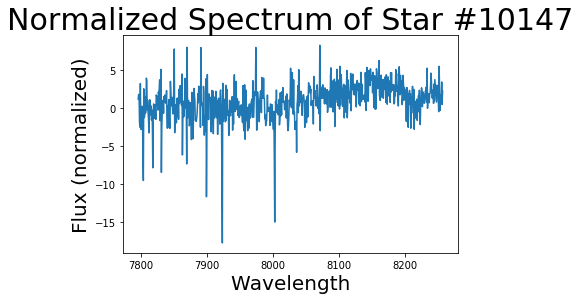

In [17]:
#graphs the normalized spectrum of any star in SPLASH
#inclues the option to graph an already-made template spectrum alongside the normalized spectrum
def graphNormSpec(star = None, spectrum = None, lower = lowerThresh, upper = upperThresh, template = False, templateSpec = None, fileName = None):
    '''
    star: the index of a particular star (with corresponding spectrum) in SPLASH
    spectrum: a Numpy array consisting of the data values that represent the flux values of a spectrum to be graphed
    lower: the lower boundary of the range the spectrum will be normalized on, in terms of wavelength
    upper: the upper boundary of the range the spectrum will be normalized on, in terms of wavelength
    template: a Boolean variable that, if True, will graph the normalized spectrum and the template spectrum on the same graph. If False, only the normalized spectrum will be graphed
    templateSpec: a Numpy array representing the flux values of the spectrum to be used as the template if template is True
    fileName: an optional argument that can be used to save the created graph as a png with the file name designated
    
    Note that in order to use the template, the functions below that are devoted to template creation must be initialized
    
    lower and upper will default to the lowerThresh and upperThresh values defined above, respectively
    template will default to False, and templateSpec will default to Ctemplate (the carbon coadd)
    star and spectrum will default to None so that either a star index or raw spectral data can be used in the function. Use the inputs that you need based on your data type and leave the other as None
    fileName will default to None, meaning the graph will not be saved as a png
   
    
    Does not return a particular value, but will produce a graph of wavelength versus flux that represents the normalized spectrum of star
    Note that gaps may be present in the spectral graph where NaN values are present in the flux measurements of a certain star
    '''
    #assigning the data to be graphed
    if star is None and np.all(spectrum is None):
        print("InputError: One of 'star' and 'spectrum' must not be None.")
        return None
    if star is not None:
        wvrange, spectrum, ivar = normSpec(star = star, lower = lower, upper = upper)[:3]
    elif np.all(spectrum is not None):
        wvrange, spectrum = data["LBIN"][0][lower:upper], spectrum
    x = wvrange.tolist()
    y = spectrum.tolist()
    
    #this if statement separates out the graphing data that is assigned if template is True
    if template is True:  #Antara - changed the default template to Wtemplate (weak CN coadd)
        y2 = templateSpec
        plt.plot(x, y, color = "b", label = "Normalized Spectrum")
        plt.plot(x, y2, color = "r", label = "Template Spectrum")
        plt.legend(fontsize = 20)
    else:
        plt.plot(x,y)
    
    #formatting the graph so that it is easily readable and executing its creation
    plt.rcParams['figure.figsize'] = 30,11 
    plt.title("Normalized Spectrum of Star #" + str(star), size = 30) 
    plt.ylabel("Flux (normalized)", size = 20)
    plt.xlabel("Wavelength", size = 20) 
    if fileName is not None:
        plt.savefig(fileName)
    else:
        plt.show()

#test execution of the function
graphNormSpec(star = 10147)

In [18]:
#a histogram-making function that condenses parameters and has constant defaults that are used in most of our histograms
#note: some features of this function are final/set-in-stone, thus only compatible where these features work

#version note: defaultHist has not been implemented/used in v2.4.0, go to 2.5.1 to see usage
def defaultHist(data, binList, colors, labels, graphLabels, xLim = None, yLim = None, dens=False,alphas = None, step = 0, fileName = None):
    '''
    main note on this function: everything should be passed in as a tuple - even if a single value, put [ ] around
   
    data: a tuple containing all the lists of data to plot on the same histogram
    binList: the Numpy array to use as bins (used for ALL data populations)
    colors: a tuple containing all the colors, corresponding to each sample in data
    labels: a tuple containing all the labels, corresponding to each sample in data
    graphLabels: a tuple of length 3 containing data for the graph: (1) title, (2) x-label, (3) y-label
    dens: a boolean that, if True, will make the histogram a density histogram - default is False
    xLim, yLim: if not None, the limits to put on the viewing rectangle of the graph
    alphas: a tuple of alpha values (transparency amounts) - default is None (no transparency)
    step: if greater than 0, implies a step histogram should be used. value is the line width for the histogram
    fileName: if not None, means this plot should be saved as a figure with this file name.
    '''
    
    for index in range(len(data)):
        a = 1
        if not alphas is None:
            a = alphas[index]
        if step > 0:
            plt.hist(data[index], bins = binList, color = colors[index], label = labels[index], histtype='step', linewidth = step, density = dens, alpha = a)
        else:
            plt.hist(data[index], bins = binList, color = colors[index], label = labels[index], density = dens, alpha = a)
    plt.rcParams['figure.figsize'] = 30,11 
    plt.title(graphLabels[0], size = 50) 
    plt.xlabel(graphLabels[1], size = 40)
    plt.ylabel(graphLabels[2], size = 40)
    plt.legend(fontsize = 35)

    if xLim is not None:
        plt.xlim(xLim)
    if yLim is not None:
        plt.ylim(yLim)
    
    if fileName is not None:
        plt.savefig(fileName)

    plt.show()


## Coadding Spectra
Includes sigma clipping for normalized spectral data, coaddition, and graphing functions. Also includes a Gaussian function to smooth spectral graphs. Creates three template spectra to be used in later score calculation methods; these include both a clipped and full-range carbon star template as well as a weak CN star template.

In [19]:
#defines a function that clips out outlier data points in a set of spectra 
#outliers are defined as points that lie outside of a certain number of standard deviations away from the median flux value at each wavelength
def sigmaClip(spectra, ivars, nsigma = 3.5):
    '''
    spectra: a list of the spectra of each star that is being clipped
    ivars: a list of the sets of ivars for each star that is being coadded
    nsigma: an integer or float representing the number of standard deviations away from the median to be used in clipping
    
    nsigma will default to 3.5 unless otherwise specified
    spectra and ivar values must be normalized and corresponding for best results
    
    Returns spectra, a list of the spectra of each star in terms of flux
    Also returns ivars, a list of the set of ivars of each star with values corresponding to the invalid values in spectra (those that lie more than nsigma standard deviations away from the median) replaced by 0s
    '''
    sortedSpecList = []
    for value in range(len(spectra[1])): #note that the use of spectra[1] is arbitrary as all of the lists in spectra have the same length
        listToAdd = []
        for spectrum in range(len(spectra)):
            if not np.isnan(spectra[spectrum][value]):
                listToAdd.append(spectra[spectrum][value])
        sortedSpecList.append(listToAdd)
    medians = []
    for eachlist in range(len(sortedSpecList)):
        if len(sortedSpecList[eachlist]) != 0:
            medians.append(st.median(sortedSpecList[eachlist]))
        else: 
            medians.append(np.nan)
        if eachlist%100 == 0 and eachlist != 0:
            print(str(eachlist) + " medians calculated.")
    for spectrum in range(len(spectra)):
        for flux in range(len(spectra[1])): #see above comment
            if np.isnan(medians[flux]):
                continue
            elif ivars[spectrum][flux] != 0 and not np.isnan(spectra[spectrum][flux]):
                testFlux = ((spectra[spectrum][flux] - medians[flux])**2)*ivars[spectrum][flux] 
                if testFlux > nsigma**2:
                    spectra[spectrum][flux] = np.nan
                    ivars[spectrum][flux] = 0          
    return spectra, ivars

In [20]:
#defines a function that will coadd normalized spectra based on provided lists of spectra and ivar weights
def coadd(spectra, ivars, lower = lowerThresh, upper = upperThresh):
    '''
    spectra: a list of the spectra of each star that is being coadded
    ivars: a list of the sets of ivars for each star that is being coadded
    lower: the lower boundary of the range the spectrum have been normalized on, in terms of wavelength
    upper: the upper boundary of the range the spectrum have been normalized on, in terms of wavelength
    
    lower and upper will default to the lowerThresh and upperThresh values defined above, respectively
    spectra and ivar values must be normalized and corresponding for best results
    
    Returns wvValues_np, a Numpy array containing every wavelength value for which spectral data exists between lower and upper
    Also returns coaddedFlux_np, a Numpy array containing the flux values of the coadded spectrum corresponding to each wavelength in wvValues_np 
    Also returns coaddedIvar_np, a Numpy array containing the ivar values of the coadded spectrum corresponding to each wavelength in  wvValues_np
    '''
    wvValues = data["LBIN"][0][lower:upper].tolist()
    coaddedFlux = []
    coaddedIvar = []
    for wv in range(len(wvValues)):
        fluxSum = 0
        ivarSum = 0
        for star in range(len(spectra)):
            if not np.isnan(spectra[star][wv]): 
                fluxSum += spectra[star][wv] * ivars[star][wv] #multiplying by ivar as a weight, as per formula
                ivarSum += ivars[star][wv]
        if ivarSum == 0:
            coaddedFlux.append(np.nan)
            coaddedIvar.append(0)
        else:
            newFlux = fluxSum/ivarSum #normalizing the weights, as per formula
            coaddedFlux.append(newFlux) #coaddedSpec now contains a coadded spectrum value at each LBIN value
            coaddedIvar.append(ivarSum) #coadded ivar is simply the sum of all ivars for a certain bin, across all stars (based on a mathematical proof)
    for flux in range(len(coaddedFlux)):
        if coaddedFlux[flux] == 0:
            coaddedFlux[flux] = np.nan
    coaddedFlux_np = np.array(coaddedFlux)
    wvValues_np = np.array(wvValues)
    coaddedIvar_np = np.array(coaddedIvar)
    return wvValues_np, coaddedFlux_np, coaddedIvar_np

In [21]:
#defines a function that applys a smoothing function to a spectrum to improve the quality of the spectrum's graph
#used in this program largely for smoothing the graphs of template spectra
def applyGauss(spectrum, gauss = 2):
    '''
    spectrum: a Numpy array containing the flux values of a pre-clipped and normalized (if applicable) star spectrum that will be smoothed
    gauss: an optional numerical argument to be used as the standard deviation of the Gaussian kernel
    
    gauss will default to 2 if no other value is provided (this value was determined based on previous work by A. Kamath)
    
    Returns smoothSpec, a Numpy array containing the modified/smoothed flux values of the original spectrum
    '''
    kernel = Gaussian1DKernel(gauss)
    smoothSpec = convolve(spectrum, kernel)
    return smoothSpec

In [22]:
#defines a function that creates a coadded template spectrum by combining several spectra normalized over a certain range
def getTempSpec(starIndices, lower = lowerThresh, upper = upperThresh, nsigma = 3.5):
    '''
    starIndices: an array or list of the indices of the stars to be coadded (which correspond to spectra in SPLASH)
    lower: the lower boundary of the range the spectrum will be normalized on, in terms of wavelength
    upper: the upper boundary of the range the spectrum will be normalized on, in terms of wavelength
    nsigma: a numerical value representing the number of standard deviations away from the flux medians that data for the coaddition will be trimmed to
    
    lower and upper will default to the lowerThresh and upperThresh values defined above, respectively
    nsigma will default to 3.5 unless another value is provided
    
    Returns coadd_wv, the set of all wavelength values for which data exists in the final coadded spectrum
    Also returns coadd_spec, the set of all flux values that correspond to the wavelength values in coadd_wv for the final coadded spectrum
    Also returns coadd_ivar, the number representing the ivar for every wavelength value on the final coadded spectrum
    Note that the final spectrum has been created from nsigma clipped data
    '''
    #creating lists of normalized spectra and ivars for each star to be coadded
    spectra = []
    ivars = []
    for star in starIndices:
        if lower == lowerThresh and upper == upperThresh:
            spectra.append(splashSpecs_dict[star].tolist())
            ivars.append(splashIvars_dict[star].tolist())
        else:
            starSpec, starIvar = normSpec(star = star, lower = lower, upper = upper)[1:3]
            spectra.append(starSpec.tolist())
            ivars.append(starIvar.tolist())
    print("Step 1 of 3 complete. Normalized spectra and inverse variances loaded.")

    #takes the original data and replaces with NaN values any data points that are greater than nsigma standard deviations from the median
    #the median is defined as the median flux at each wavelength when the flux values for every spectrum at that wavelength are considered
    spectra_new, ivars_new = sigmaClip(spectra, ivars, nsigma)
    print("Step 2 of 3 complete. Spectral and ivar data clipped to " + str(nsigma) + " sigmas.")

    #performs the coaddition with the edited data from the last step
    coadd_wv, coadd_spec, coadd_ivar = coadd(spectra_new, ivars_new, lower, upper)
    print("Step 3 of 3 complete. Coaddition of spectra and ivars performed and template created.")
    
    return coadd_wv, coadd_spec, coadd_ivar

In [23]:
Ctemplate_wv, Ctemplate, Ctemplate_ivar = getTempSpec(allcarbon)
Ctemplate_wv_full, Ctemplate_full, Ctemplate_ivar_full = getTempSpec(allcarbon, lower = fullSpec_low, upper = fullSpec_high)
Wtemplate_wv, Wtemplate, Wtemplate_ivar = getTempSpec(wNm)


Step 1 of 3 complete. Normalized spectra and inverse variances loaded.
100 medians calculated.
200 medians calculated.
300 medians calculated.
400 medians calculated.
500 medians calculated.
600 medians calculated.
700 medians calculated.
Step 2 of 3 complete. Spectral and ivar data clipped to 3.5 sigmas.
Step 3 of 3 complete. Coaddition of spectra and ivars performed and template created.
NormalizationError: The spectrum for star 22283 contains only NaN values on the specified range. It cannot be normalized.
Step 1 of 3 complete. Normalized spectra and inverse variances loaded.
100 medians calculated.
200 medians calculated.
300 medians calculated.
400 medians calculated.
500 medians calculated.
600 medians calculated.
700 medians calculated.
800 medians calculated.
900 medians calculated.
1000 medians calculated.
1100 medians calculated.
1200 medians calculated.
1300 medians calculated.
1400 medians calculated.
1500 medians calculated.
1600 medians calculated.
1700 medians calculated

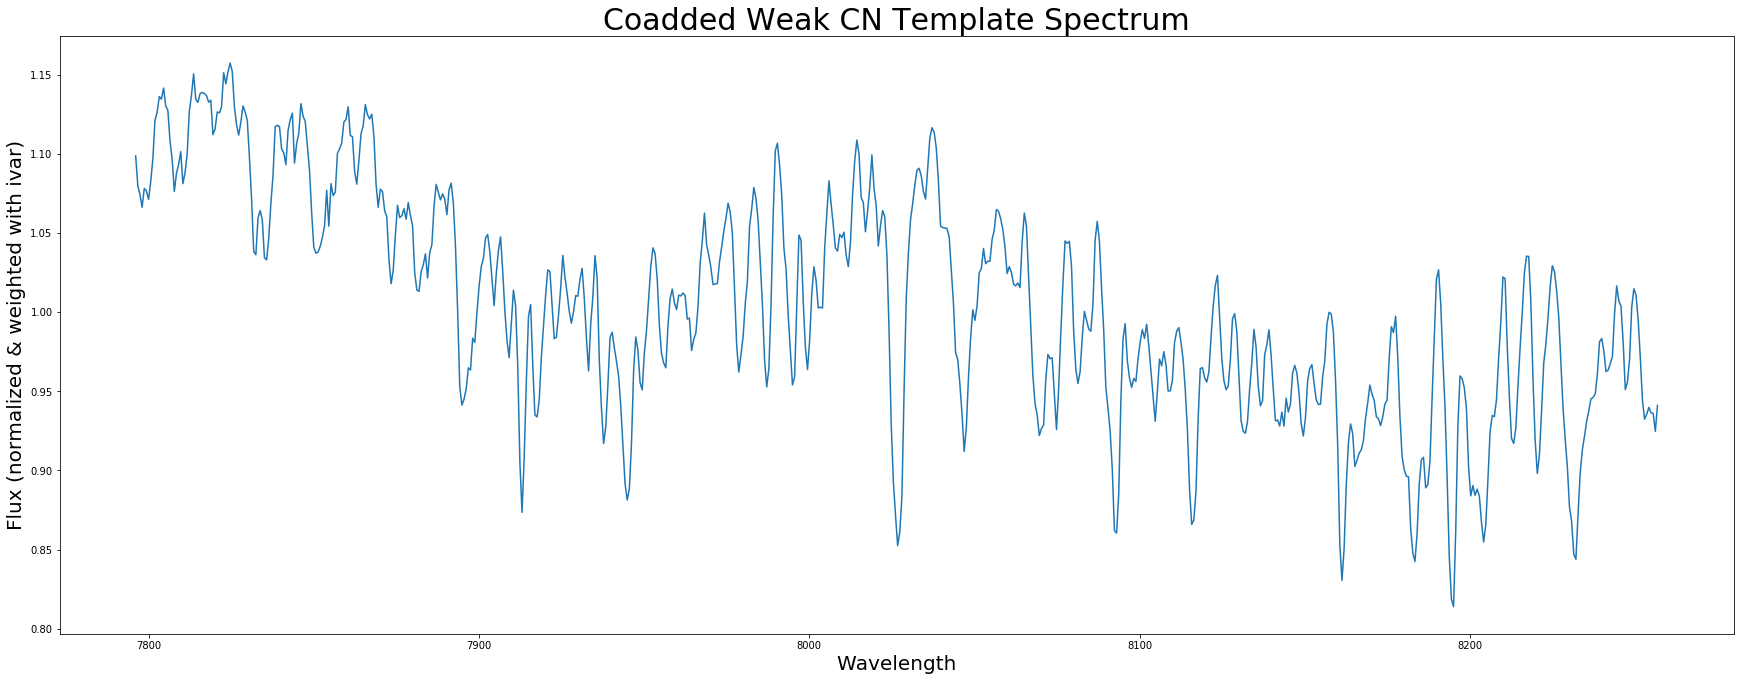

In [24]:
#graphs the limited-range carbon template spectrum created from the above function
#Antara - changed code to work with Wtemplate instead of Ctemplate
x = Wtemplate_wv.tolist()
y = Wtemplate.tolist()
plt.rcParams['figure.figsize'] = 30,11
plt.plot(x, y)
plt.title("Coadded Weak CN Template Spectrum", size = 30)
plt.ylabel("Flux (normalized & weighted with ivar)", size = 20)
plt.xlabel("Wavelength", size = 20)
plt.show()

## Three possible ways to do the analysis
- seperate based on red/blue stars on CMD
- based on strength using chi-sq
- based on visual class or strength from 4 slope method

## Ivar Analysis (Plotting & Trimming)
Focuses on analyzing ivars of different stars in order to further process and analyze spectral data. First, creates plots of ivar vs brightness to look for correlation between high ivar and high brightness (as a measure of affirmation that high ivar values are not unfounded). Then, trims the PHAT keckPhotoOthers sample set to match weak CN and carbon in terms of normalized distribution of ivars.
End result is two samples of others stars, others1 and others2, which match the weak CN and carbon ivar distributions, respectively.

### Part 1: Ivar v. Brightness Analysis

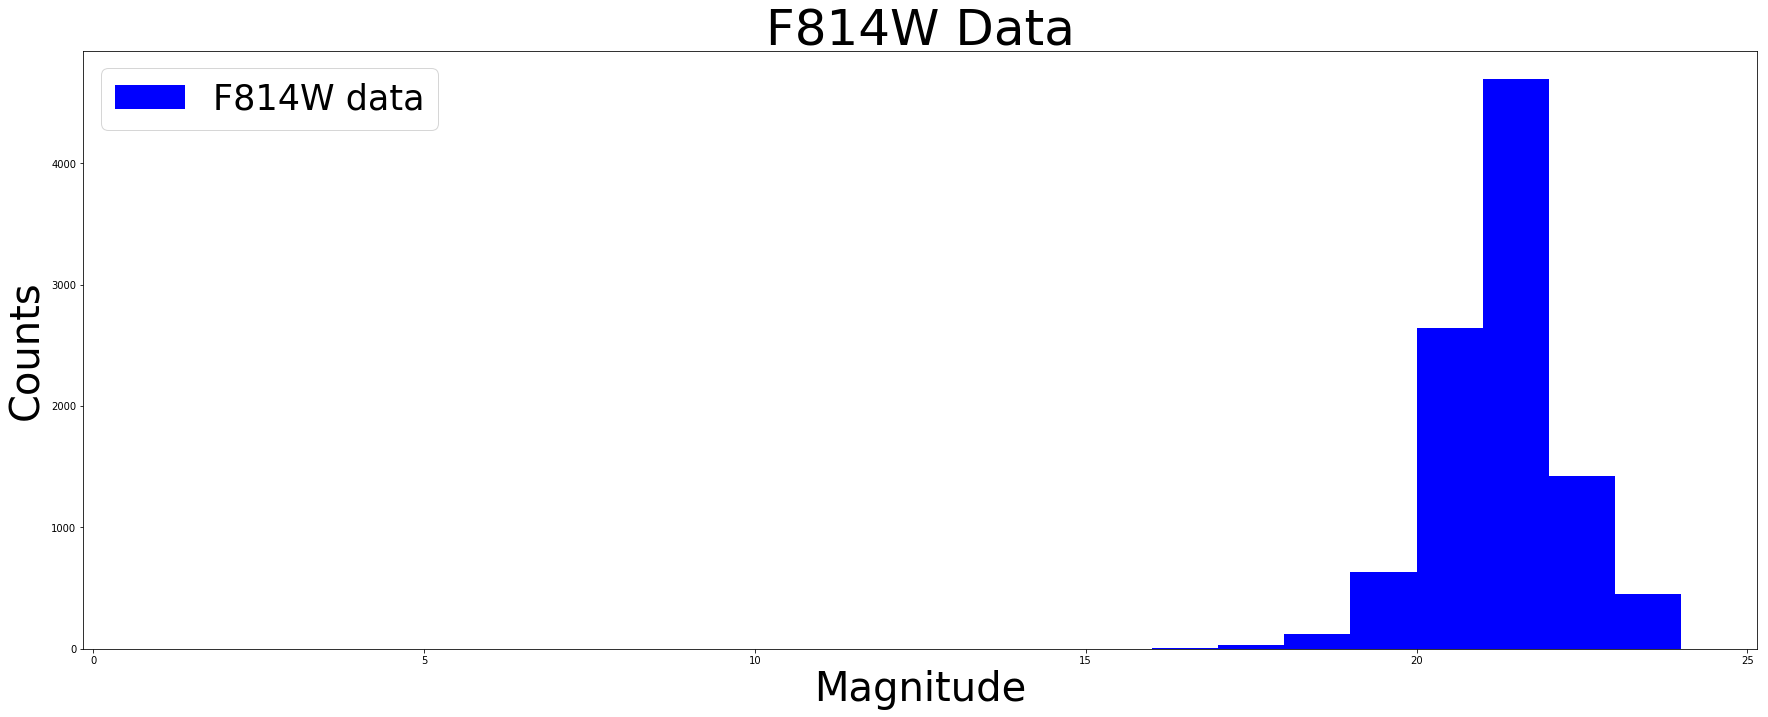

In [25]:
#makes a histogram of the F814W data, to get a general sense of the distribution
defaultHist([data['F814W'][~np.isnan(data["F814W"])]], np.arange(1, 25), ["b"], ["F814W data"], ("F814W Data", "Magnitude", "Counts"))

In [30]:
#creates the data needed to make a scatter plot of IVAR v MAGNITUDE 
#goal: check if extremely high ivar is really correct
#implementation note: can't use the ivarMeds lists because need to know the star itself (to determine the brightness)
x, y, wNm_x, wNm_y, carb_x, carb_y, kphO_x, kphO_y = [], [], [], [], [], [], [], [] #creating lists that will be filled with the coordinates for each star
highIvarNaN = wNmIvarNaN = carbIvarNaN = kphOIvarNaN  = 0 #defining counters that will be used to keep track of how many stars have NaN values in the F814W dataset
SAMPLE_OTHERS = False #this boolean represents a flag of whether to plot the full photo others (False), or only a 10% sample (True)
REMOVE_OVERLAP = True #this boolean represents a flag of whether to remove the high star data from the control data (since that is where they originate from, really)
                      #if REMOVE_OVERLAP is true, then the stars in the wNm, carbon, and kphOthers control groups will NOT have the highIvarStars data in them

print("Flag states:", "SAMPLE_OTHERS =", SAMPLE_OTHERS, 'and', "REMOVE_OVERLAP =", REMOVE_OVERLAP)
#create the x and y data for the high ivar stars: x = median of ivars, y = F814W magnitude
for star in highIvarStars:
    x.append(np.nanmedian(splashIvars_dict[star])) #these stars MUST have non-0, non-NaN ivars, due to their construction as "high ivar stars"
    y.append(data["F814W"][star])
    if np.isnan(data["F814W"][star]): #gathering metadata on cardinality of brightness-NaN-subset of highIvar
        highIvarNaN += 1
        
print('The following stars overlap in wNm and highIvarStars.') 
wNmOverlap = 0
for star in wNm: #control group 1: weak CN stars
    if star not in wNm_ivarMeds_dict: #ensures that stars whose spectra could not be normalized are skipped over
        continue
    if not REMOVE_OVERLAP or (REMOVE_OVERLAP and star not in highIvarStars):
        med = wNm_ivarMeds_dict[star]
        wNm_x.append(med) #if REMOVE_OVERLAP is False, this will be the same as wNm_ivarMeds; otherwise, it is no-highIvarStar clipped version
        wNm_y.append(data["F814W"][star])
    if star in highIvarStars: #gathering metadata on the stats of high-IVAR stars and their distribution in SPLASH
        print(star, "median ivar =", med)
        wNmOverlap += 1
    if np.isnan(data["F814W"][star]): #gathering metadata on cardinality of brightness-NaN-subset of wNm
        wNmIvarNaN += 1
if wNmOverlap == 0:
    print("NONE")
        

print('The following stars overlap in carbon and highIvarStars.')
cOverlap = 0
for star in allcarbon: #control group 2: carbon stars
    if star not in carbon_ivarMeds_dict: #ensures that stars whose spectra could not be normalized are skipped over
        continue
    if not REMOVE_OVERLAP or (REMOVE_OVERLAP and star not in highIvarStars):
        med = carbon_ivarMeds_dict[star]
        carb_x.append(med) #if REMOVE_OVERLAP is False, this will be the same as carbon_ivarMeds; otherwise, it is no-highIvarStar clipped version
        carb_y.append(data["F814W"][star])
    if star in highIvarStars: #gathering metadata on the stats of high-IVAR stars and their distribution in SPLASH
        cOverlap += 1
        print(star, "median ivar =", med)
    if np.isnan(data["F814W"][star]): #gathering metadata on cardinality of brightness-NaN-subset of carbon
        carbIvarNaN += 1
if cOverlap == 0:
    print("NONE")

print('The following stars overlap in the control group of PHAT-others and highIvarStars.')
oOverlap = 0
if SAMPLE_OTHERS:
    picker = 0
    print('SAMPLE_OTHERS = TRUE, so this is not ALL of the stars in highIvarStars from keckPhotoOthers; since this is a 10% sample, it is likely 10% the actual, larger number.')
for star in keckPhotoOthers: #control group 3: keckPhotoOthers (with possibility of randomized 10% subset)
    if SAMPLE_OTHERS:
        picker += 1
        if not picker % 10 == randrange(0, 9, 1): #generates a random number to use, will pick ~1/10 the subset
            continue
    if star not in kphOthers_ivarMeds_dict: #ensures that stars whose spectra could not be normalized are skipped over
        continue
    currentMed = kphOthers_ivarMeds_dict[star]
    if not REMOVE_OVERLAP or (REMOVE_OVERLAP and star not in highIvarStars):
        kphO_x.append(currentMed)
        kphO_y.append(data["F814W"][star])
    if star in highIvarStars: #gathering metadata on the stats of high-IVAR stars and their distribution in SPLASH
        print(star, "median ivar =", currentMed)
        oOverlap += 1
    if np.isnan(data["F814W"][star]):
        kphOIvarNaN += 1 #this will likely be 0 (although not certain, due to "OR" condition in keckPhotoOthers construction)
if oOverlap == 0:
    print("NONE")
    
#printing out metadata for debugging/testing uses        
print("Brightness NaN counts (highIvar, wNm, carbon, kphO):", highIvarNaN, wNmIvarNaN, carbIvarNaN, kphOIvarNaN) #check to see how many of each type don't have data in F814W 
print("Total Stars (highIvar, wNm, carbon, kphO):", len(x), len(wNm_y), len(carb_y), len(kphO_y))
print("Overlaps (wNm, carbon, kphO):", wNmOverlap, cOverlap, oOverlap)
print("Maximum Ivar Found:", np.max(x))

('Flag states:', 'SAMPLE_OTHERS =', False, 'and', 'REMOVE_OVERLAP =', True)
The following stars overlap in wNm and highIvarStars.
(20903, 'median ivar =', 262.89997553928066)
(21555, 'median ivar =', 110.2616634990361)
(24483, 'median ivar =', 93.30942519182388)
(24926, 'median ivar =', 138.34087599596683)
(20291, 'median ivar =', 604.6909361239703)
(20320, 'median ivar =', 486.30066856688643)
(21069, 'median ivar =', 19.51136386467212)
(21305, 'median ivar =', 185.83203399376632)
(21308, 'median ivar =', 185.83203399376632)
(21323, 'median ivar =', 185.83203399376632)
(21474, 'median ivar =', 135.62499996532108)
(21588, 'median ivar =', 250.98972966615247)
(21729, 'median ivar =', 69.82537781146353)
(21821, 'median ivar =', 69.82537781146353)
(21858, 'median ivar =', 69.82537781146353)
(22009, 'median ivar =', 178.11910531903385)
(22569, 'median ivar =', 150.37443675864526)
(22602, 'median ivar =', 167.72658420556075)
(23596, 'median ivar =', 98.45840943921644)
(23693, 'median ivar ='

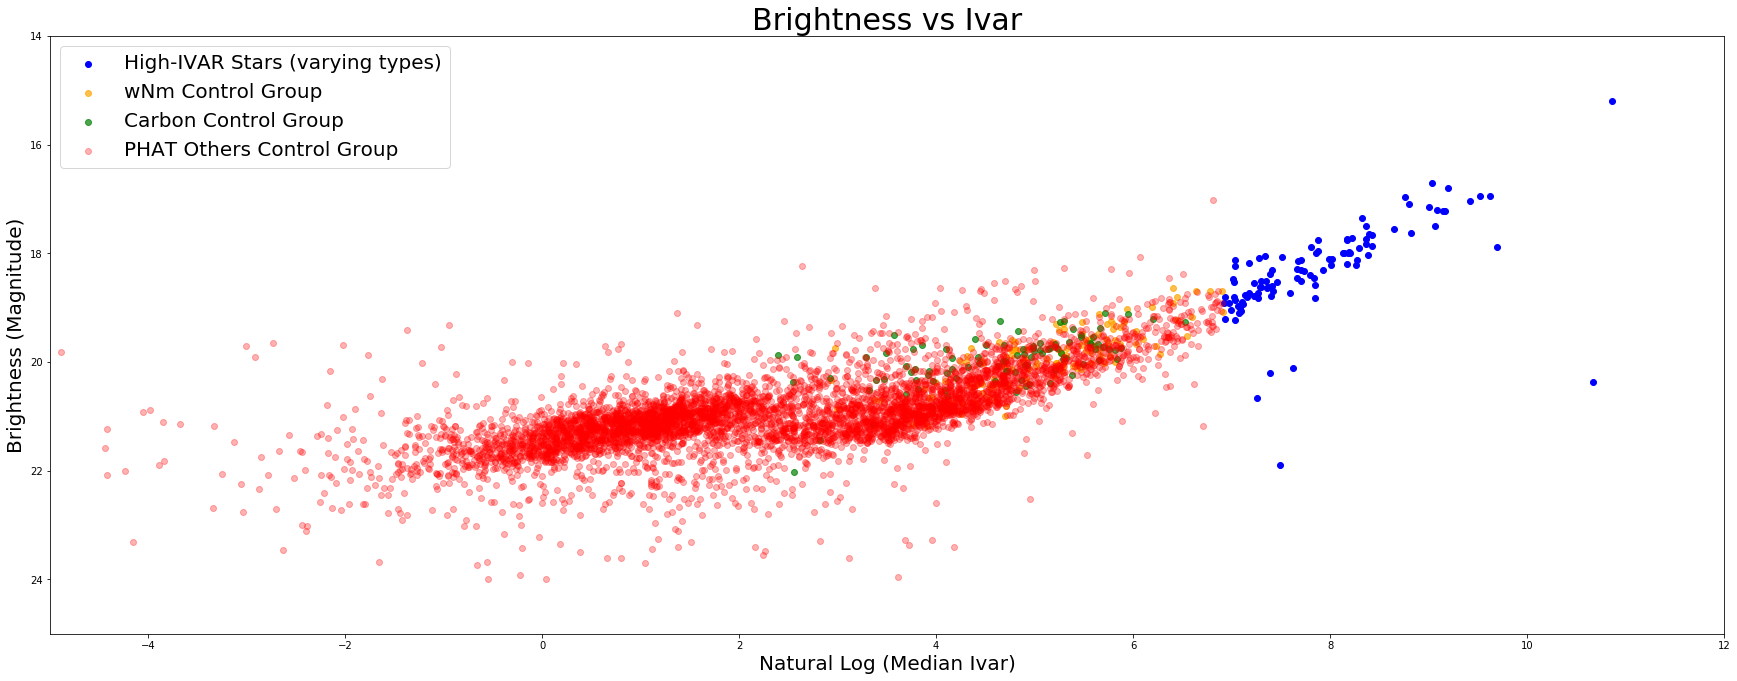

In [31]:
#creates the scatter plots of the star ivars vs brightness
#note that the dataset is split into the highIvarStars, and wNm and carbon as controls
plt.scatter(np.log(x), y, color = 'b', label = "High-IVAR Stars (varying types)")
plt.scatter(np.log(wNm_x), wNm_y, color = 'orange', alpha = 0.7, label = "wNm Control Group")
plt.scatter(np.log(carb_x), carb_y, color = 'g', alpha = 0.7, label = "Carbon Control Group")
plt.scatter(np.log(kphO_x), kphO_y, color = 'r', alpha = 0.3, label = "PHAT Others Control Group")

#formatting the graph to make it easier to read
plt.xlim(-5, 12) #after 17000, just a few outliers (some ~20000, 2 ~ 50000, 1 ~ 180000, 1 ~ 225000), with magnitudes ~16, 15, 13
#only 2 kPH stars with ivars < natlog -7
plt.ylim(25, 14)
plt.rcParams['figure.figsize'] = 30,11 
plt.title("Brightness vs Ivar", size = 30) 
plt.ylabel("Brightness (Magnitude)", size = 20)
plt.xlabel("Natural Log (Median Ivar)", size = 20)
plt.legend(fontsize = 20)
#plt.savefig('brightVivar.png')
plt.show()

### Part 2: Ivar Histograms (observing distributions)

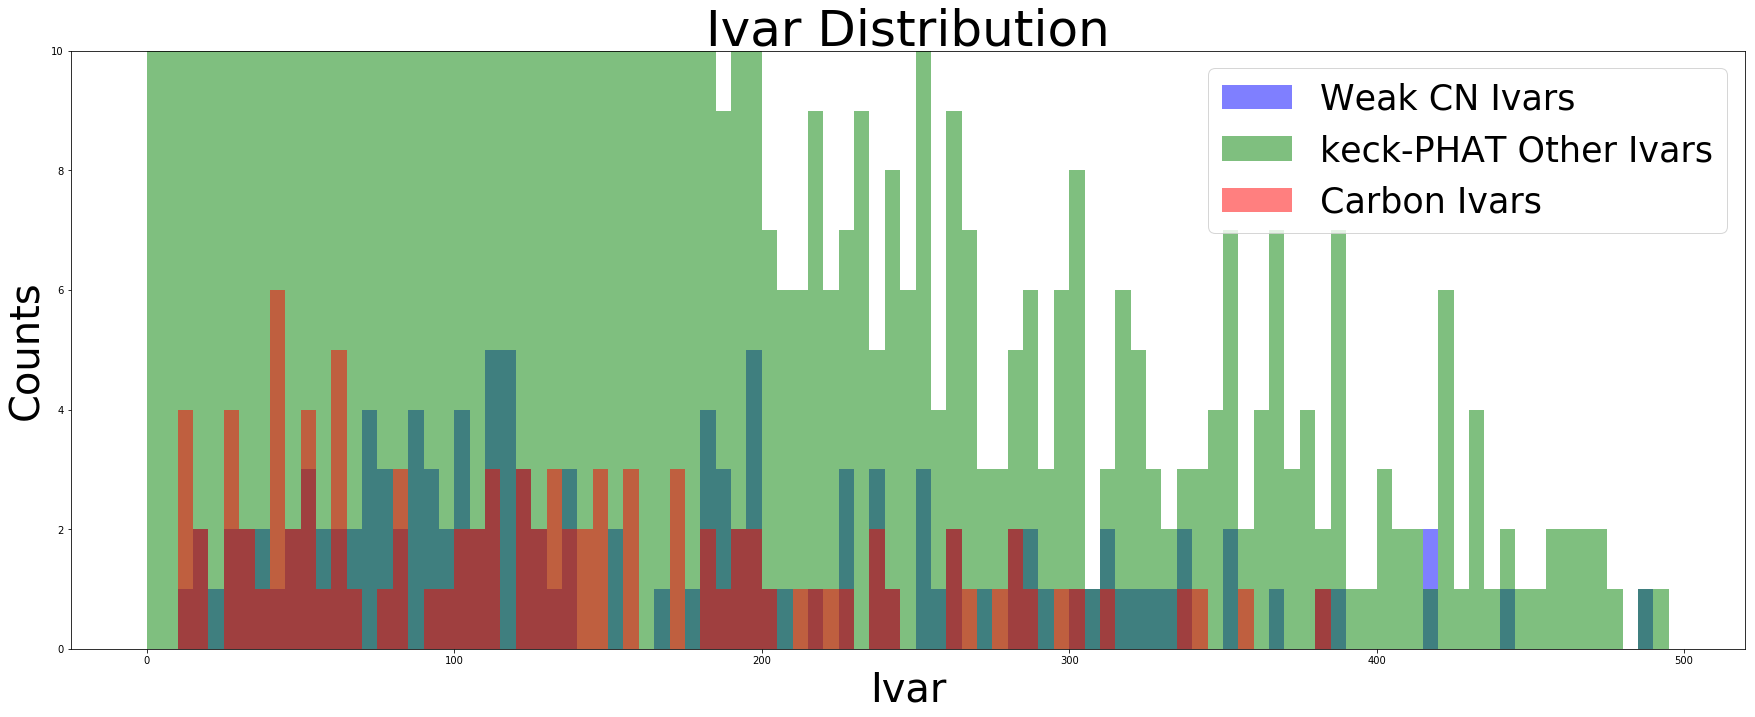

In [32]:
#create a histogram of ivars for different types of stars to provide insight into distribution of uncertainty for wNm, carbon, and other stars
binList = np.arange(0, 500, 5)
defaultHist([wNm_ivarMeds, kphOthers_ivarMeds, carbon_ivarMeds], binList, 
            ('b', 'g', 'r'), ("Weak CN Ivars", "keck-PHAT Other Ivars", "Carbon Ivars"), ("Ivar Distribution", "Ivar", "Counts"),
            yLim = (0,10), alphas = (0.5,0.5,0.5))

#note: yLim is optional, remove for full version

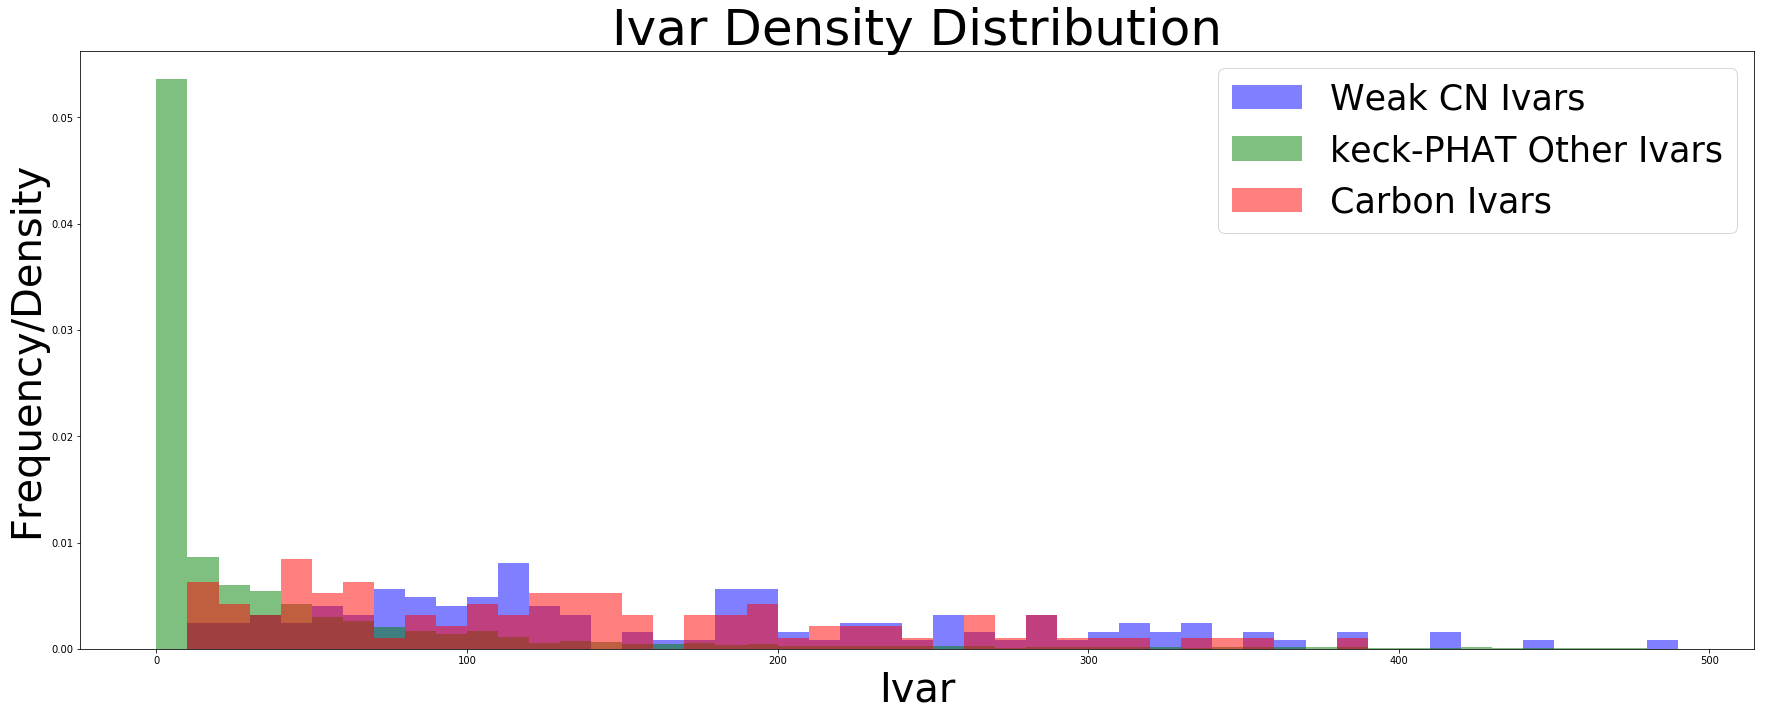

In [33]:
#creates a density histogram of the ivars for different types of stars
binList = np.arange(0, 500, 10)
defaultHist([wNm_ivarMeds, kphOthers_ivarMeds, carbon_ivarMeds], binList, 
            ('b', 'g', 'r'), ("Weak CN Ivars", "keck-PHAT Other Ivars", "Carbon Ivars"), ("Ivar Density Distribution", "Ivar", "Frequency/Density"),
            dens=True, alphas = (0.5,0.5,0.5))
plt.show()

### Part 3: Trimming Based on Ivars

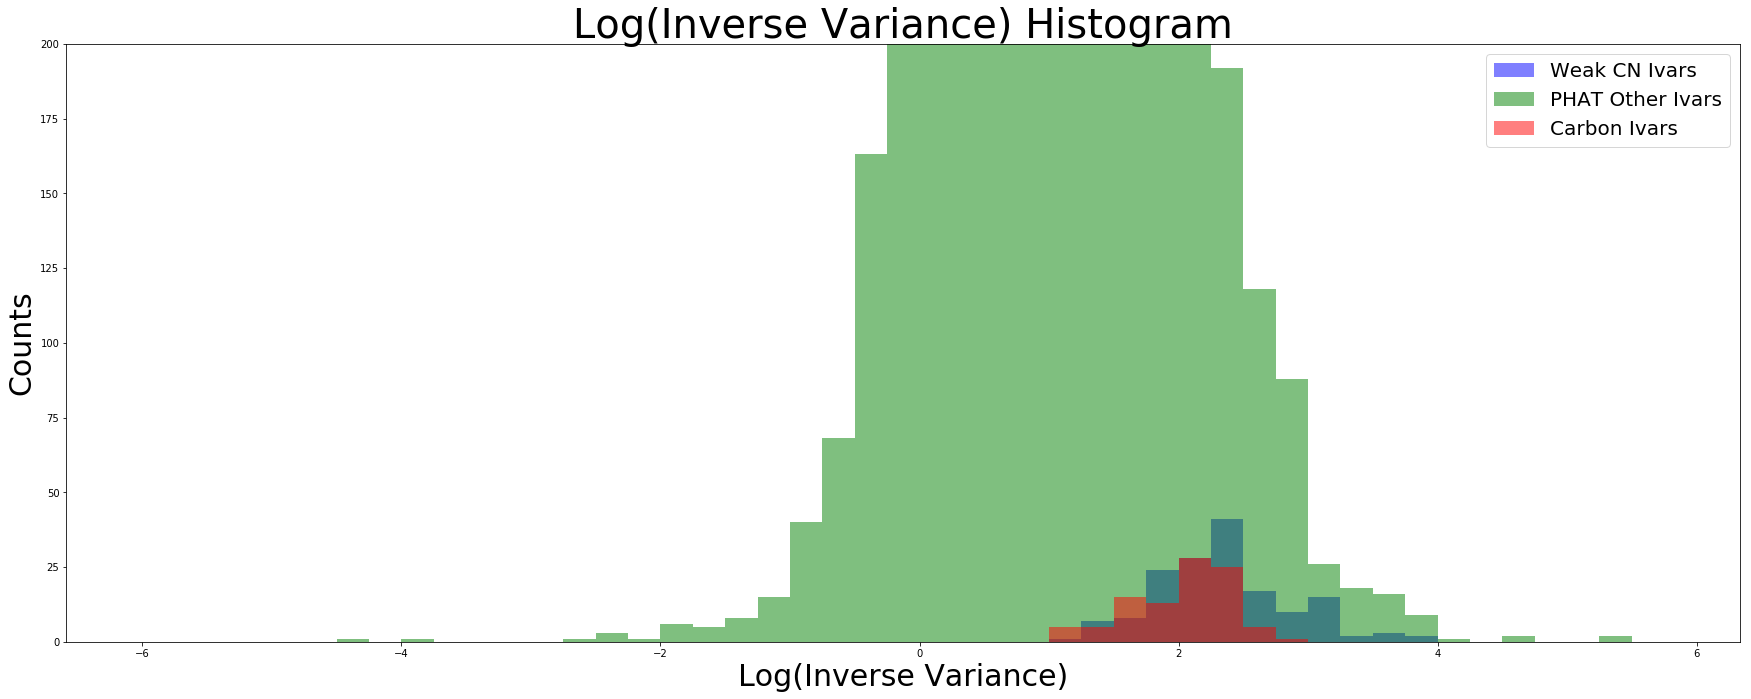

In [34]:
#method of ivar trimming: take a ratio based on high-ivar ratio
#step 1: create histogram based on log (ivar), step sizes of 1.5
binList = np.arange(-6, 6, 0.25) #largest value ~160000

wNm_logHighData = plt.hist(np.log(wNm_ivarMeds)/np.log(10), bins = binList, color = "b", alpha = 0.5, label = "Weak CN Ivars")
kphO_logHighData = plt.hist(np.log(kphOthers_ivarMeds)/np.log(10), bins = binList, color = "g", alpha = 0.5, label = "PHAT Other Ivars")
carb_logHighData = plt.hist(np.log(carbon_ivarMeds)/np.log(10), bins = binList, color = "r", alpha = 0.5, label = "Carbon Ivars")
plt.legend(fontsize = 20)
plt.title("Log(Inverse Variance) Histogram", fontsize = 40)
plt.xlabel("Log(Inverse Variance)", fontsize = 30)
plt.ylabel("Counts", fontsize = 30)
plt.ylim(0, 200)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rcParams['figure.figsize'] = 30, 11
#plt.savefig('logivar_histbase.png')
plt.show()

In [35]:
#step 2: find ratios of other stars to wNm and carbon stars at high ivars, which will be applied to lower ivars to clip the sample
#finding ratio for others1 (high kphOthers:high wNm)
#note: bucket with high-ivar values (log IVAR_LIMIT = log 1000 = 3) is index 36
highKphOSum = highwNmSum = 0
for i in range(36, len(kphO_logHighData[0])):
    highKphOSum += kphO_logHighData[0][i]
    highwNmSum += wNm_logHighData[0][i]
others1R = highKphOSum/highwNmSum

#finding ratio for others2 (kphOthers:carbon) after 10^2.5 (~316)
#note: bucket with high-ivar values (log IVAR_LIMIT = log 10^2.5 = 2.5) is index 34
highKphOSum = highCarbSum = 0
for i in range(34, len(kphO_logHighData[0])):
    if not carb_logHighData[0][i] == 0: #stops the ratio from going beyond 700-ish, as the carbon stars are limited by that value but the other stars are not
        highKphOSum += kphO_logHighData[0][i]
        highCarbSum += carb_logHighData[0][i]
others2R = highKphOSum/highCarbSum

print('others1:', others1R, '|', 'others2:', others2R)

('others1:', 3.3636363636363638, '|', 'others2:', 34.333333333333336)


In [36]:
#helper function for trimStars
#defines a function which will give a fraction (probability) to run through trimStars, based on bin-based-ratio
def ratioLim(sampleData, medIvar, ratio, modelData):   
    '''
    algorithm
    a. find bin which this ivar falls under
    b. multiply the count of weakCN/carbon (model population) by the constant ratio previously created for that bin
    c. divide the result of (b) by the total number of stars in the current bin from the kphOthers population (the one to trim)
    
    sampleData: the dataset that you wish to clip/modify based on ivar
    medIvar: the ivar to operate with
    ratio: a numerical value representing the ratio of other stars population to model carbon/weak CN population previously found 
    modelData: the dataset that you are trying to match the sampleData to through ivar clipping
    buckets: the buckets with which to operate - if the log-ivar histogram bins are changed, then this must be changed as well
    
    Note that buckets will default to an array from 0 to 6 with a step size of 0.25 unless otherwise assigned
    
    Returns a numerical value representing a probability that will be used to choose a certain number of stars from the sample population
    '''
    buckets = sampleData[1]
    logIv = np.log(medIvar)/np.log(10)
    step = buckets[1] - buckets[0]
    index = int((logIv - buckets[0])/step)
    goalCount = ratio*modelData[0][index]
    return goalCount/sampleData[0][index]

In [37]:
#defines a function that takes in a sample of stars and trims that sample according to the ivars of those stars
def trimStars(starSample, medIvDict, modelData, ratio, sampleData):
    '''
    starSample: the sample of stars that you wish to trim based on ivar
    medIvDict: a dictionary of the median ivars for the stars in starSample; keys are the indices of the stars and values are the median ivars
    modelData: the model histogram data for bin-based ratio calculation (wNm_logHighData or carb_logHighData)
    ratio: the ratio of other:model to use for trimming the starSample dataset
    sampleData: the sample histogram data for bin-based ratio calculation (kphO_logHighData); a 2D array representing the histogram frequencies/bins that were used to find the ratio
    
    Returns pickStar, an array of Boolean values corresponding to the stars in starSample. True indicates that the star should be selected and False indicates that it should not be selected
    Also returns trimmed_ivarMeds, an array containing the median ivar values for each of the stars in the new trimmed sample. In other words, these median ivars correspond to the "True"s in the pickStar array
    '''
    pickStar = np.zeros(len(starSample), dtype = bool)
    trimmed_ivarMeds = []
    index = 0
    for star in starSample: #set to choose from is keckPhotoOthers (not the entire others set)
        if star not in medIvDict:
            index += 1 #must actually skip this index in pickStar, on top of just moving to next star
            continue
        starMedIvar = medIvDict[star]
        
        #find the fraction to pick, and thus probability of picking, based on the function: limFunc(starMedIvar)
        pickFraction = ratioLim(sampleData, starMedIvar, ratio, modelData)
        if random.random() < pickFraction: #random.random() generates a floating point number from [0.0, 1.0)
            pickStar[index] = True #this star will be picked for the new sample
            trimmed_ivarMeds.append(starMedIvar) #add this star's median ivar to a list, to plot in the new normalized histogram
        index += 1
    return pickStar, trimmed_ivarMeds

In [38]:
#creating trimmed others1 and others2 samples based on the ivar-trimming functions above
chosenStars1, kphTrimmedOthers1_ivarMeds = trimStars(keckPhotoOthers, kphOthers_ivarMeds_dict, wNm_logHighData, others1R, kphO_logHighData)
kphTrimmedOthers1 = np.array(keckPhotoOthers)[chosenStars1]
chosenStars2, kphTrimmedOthers2_ivarMeds = trimStars(keckPhotoOthers, kphOthers_ivarMeds_dict, carb_logHighData, others2R, kphO_logHighData)
kphTrimmedOthers2 = np.array(keckPhotoOthers)[chosenStars2]

### Part 4: New Ivar Histograms & Analysis of Trimmed Data

('Post-Clipping Size in wNm-Based Trimming:', 525)
('Original Size:', 5586)


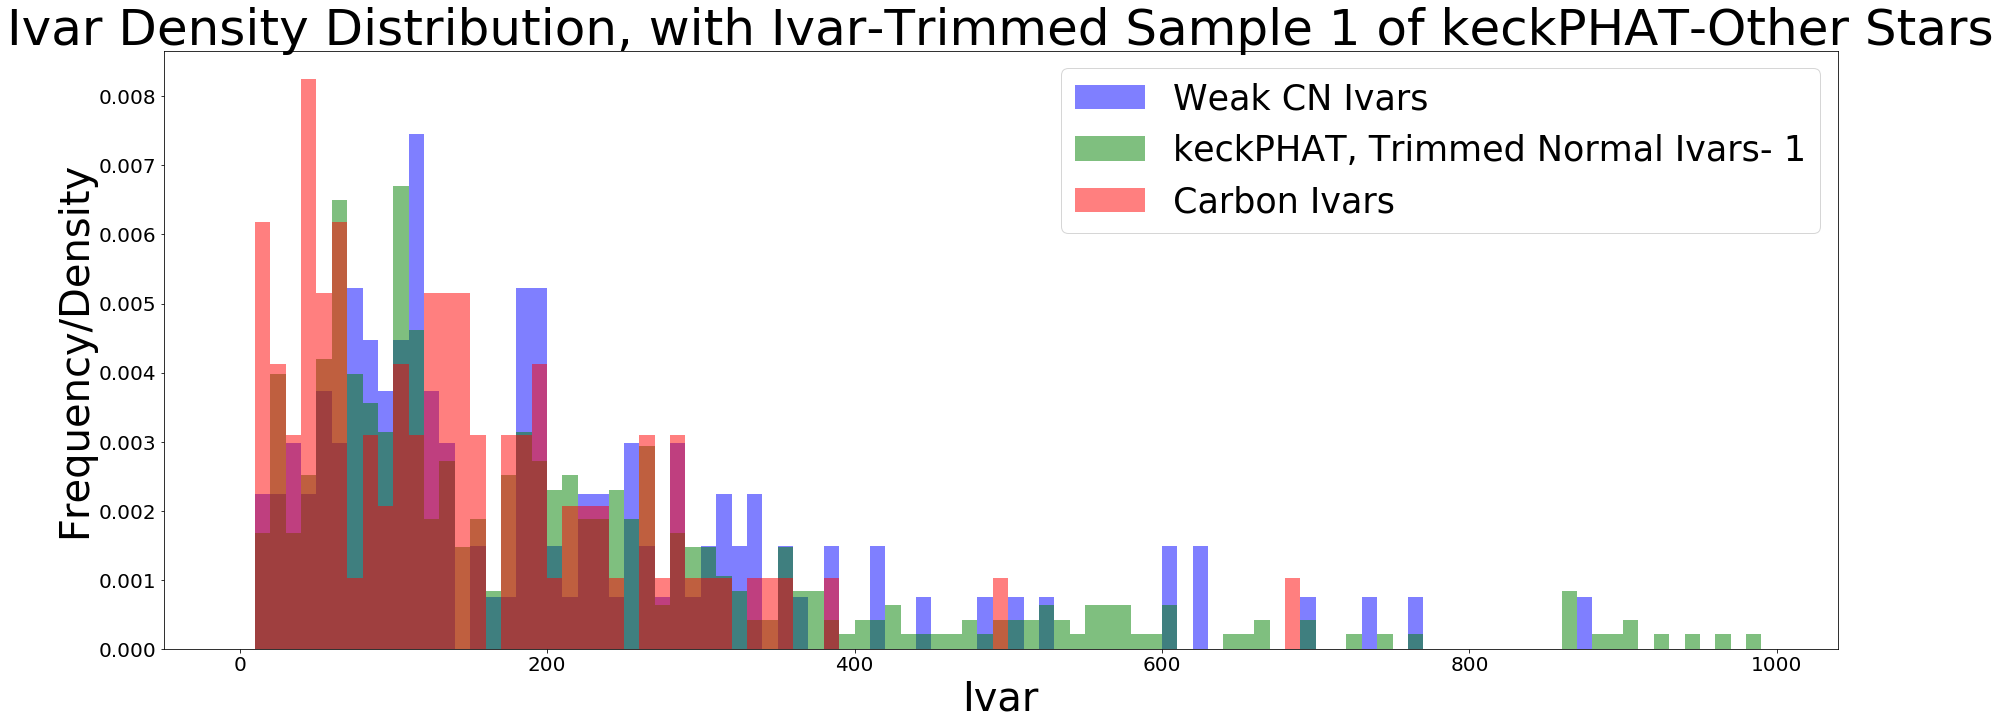

In [39]:
#wNm-based trimming - histogram/data analysis
#goal: make the two ivar distributions (others1 and weak CN) as similar as possible
print("Post-Clipping Size in wNm-Based Trimming:", len(kphTrimmedOthers1))
print("Original Size:", len(keckPhotoOthers))

#creating + formatting the histogram
binList = np.arange(0, 1000, 10)
defaultHist([wNm_ivarMeds, kphTrimmedOthers1_ivarMeds, carbon_ivarMeds], binList, 
            ('b', 'g', 'r'), ("Weak CN Ivars", "keckPHAT, Trimmed Normal Ivars- 1", "Carbon Ivars"), 
            ("Ivar Density Distribution, with Ivar-Trimmed Sample 1 of keckPHAT-Other Stars", "Ivar", "Frequency/Density"),
             dens=True,alphas = (0.5,0.5,0.5), fileName="ivarDensity_hist_others1")

('Post-Clipping Size in Carbon-Based Trimming:', 1970)
('Original Size:', 5586)


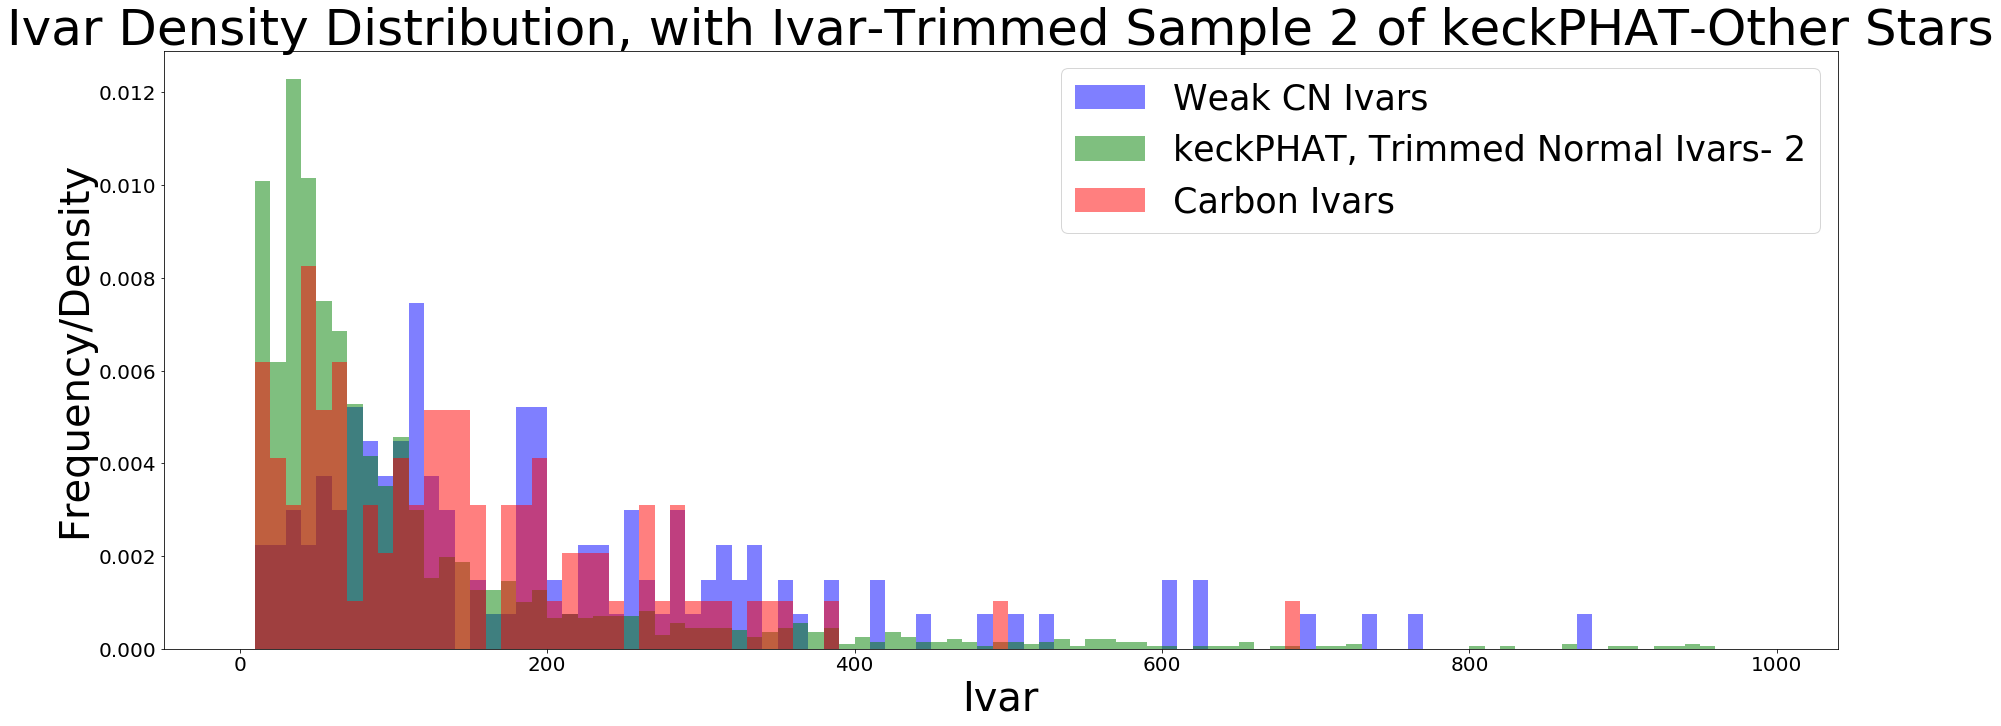

In [40]:
#carbon-based trimming - histogram/data analysis
#goal: make the two ivar distributions (others2 and carbon) as similar as possible
print("Post-Clipping Size in Carbon-Based Trimming:", len(kphTrimmedOthers2))
print("Original Size:", len(keckPhotoOthers))

#creating and formatting the histogram
binList = np.arange(0, 1000, 10)
defaultHist([wNm_ivarMeds, kphTrimmedOthers2_ivarMeds, carbon_ivarMeds], binList, 
            ('b', 'g', 'r'), ("Weak CN Ivars", "keckPHAT, Trimmed Normal Ivars- 2", "Carbon Ivars"), 
            ("Ivar Density Distribution, with Ivar-Trimmed Sample 2 of keckPHAT-Other Stars", "Ivar", "Frequency/Density"),
             dens=True,alphas = (0.5,0.5,0.5), fileName="ivarDensity_hist_others2")

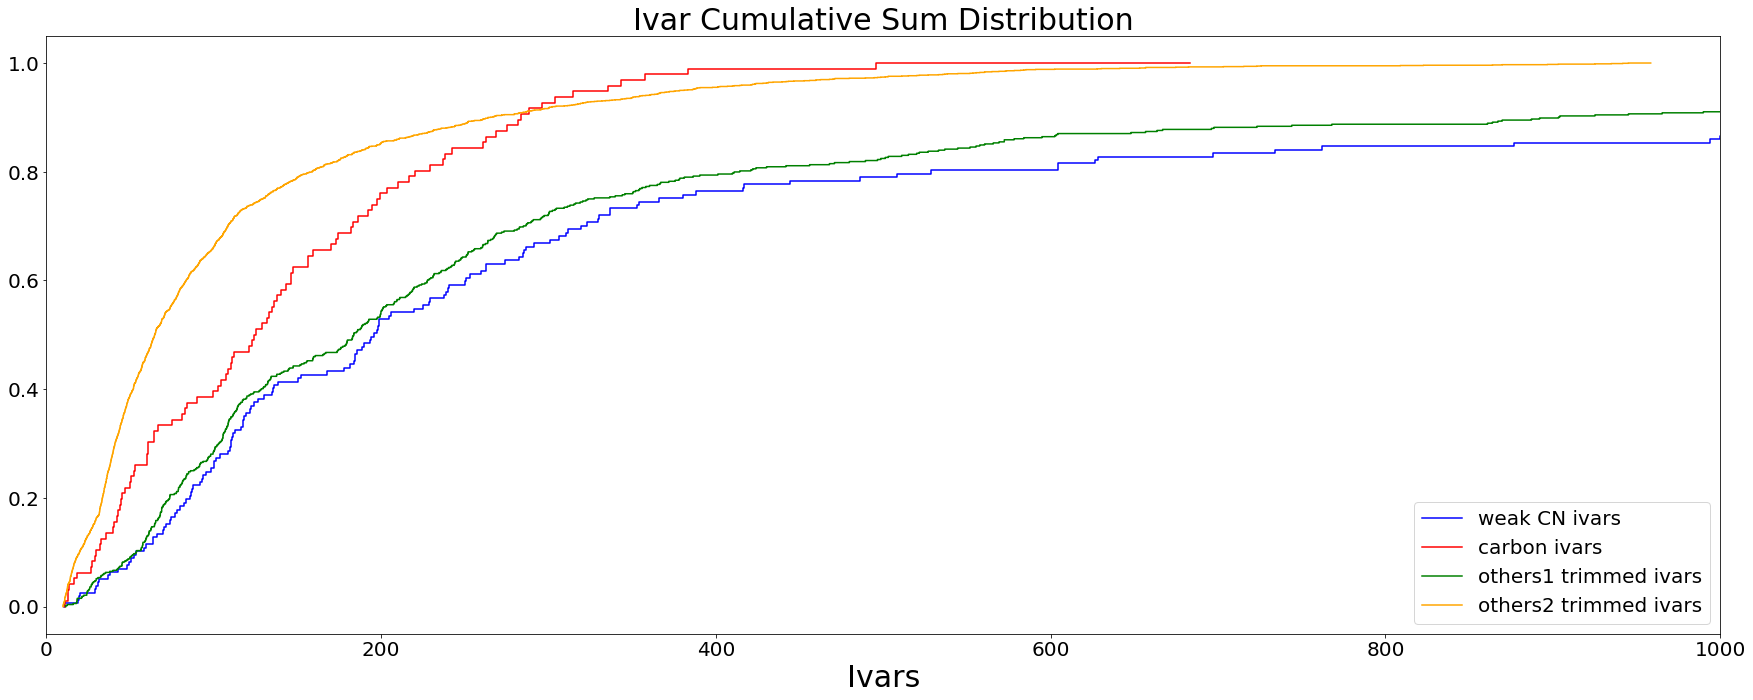

In [41]:
#making unbinned cumulative distribution plots, based on a step of 1/N for each data point
#step 1: sorting the data
wNm_sortedMeds = np.sort(wNm_ivarMeds)
carb_sortedMeds = np.sort(carbon_ivarMeds)
kphO1_sortedMeds = np.sort(kphTrimmedOthers1_ivarMeds)
kphO2_sortedMeds = np.sort(kphTrimmedOthers2_ivarMeds)

#step 2: make the cumulative sum as a step function with a step size of 1 / N (where N is set size), so all samples' y's end at 1
plt.step(wNm_sortedMeds, np.linspace(0, 1, len(wNm_sortedMeds)), color = 'blue', label = "weak CN ivars")
plt.step(carb_sortedMeds, np.linspace(0, 1, len(carb_sortedMeds)),  color = 'red', label = "carbon ivars")
plt.step(kphO1_sortedMeds, np.linspace(0, 1, len(kphO1_sortedMeds)), color = 'green', label = "others1 trimmed ivars")
plt.step(kphO2_sortedMeds, np.linspace(0, 1, len(kphO2_sortedMeds)), color = 'orange', label = "others2 trimmed ivars")

#formatting the chart so that it is easy to read
plt.title("Ivar Cumulative Sum Distribution", size = 30) 
plt.xlabel("Ivars", size = 30)
plt.legend(fontsize = 20)
plt.xlim(0, 1000)
#plt.savefig('ivarDistr_cumulativeSum_others1+2_raw.png')
plt.show()

### Part 5: Further Cleaning of Others2 Data
Goal: to make the others2 sample better match the carbon star sample in terms of ivar distribution. Current methods: don't keep any stars with ivar > 700, from 0 - 100 keep only 30% of stars (evenly distributed in range after sorting; i.e. 1, 5, 9 in every interval of 10), and from 450 - 700 keep only 10% of stars (after sorting, only star 4 in every interval of 10).

In [42]:
#performs the clean-up of the others2 sample based on the methods described above
keep = []
keepIvars = []
UPPER_LIM = 700 #no carbon stars have median ivars beyond 700

kphTrimmed2_dict = {}
for star in kphTrimmedOthers2:
    kphTrimmed2_dict[star] = kphOthers_ivarMeds_dict[star] #all stars in kphTrimmedOthers2 are in ivarMeds dictionary, but not vice versa

ctr = 1
for star in sorted(kphTrimmed2_dict, key = kphTrimmed2_dict.get):
    ctr = ctr % 10
    keepStar = True
    if star not in kphOthers_ivarMeds_dict:
        continue
    med = kphOthers_ivarMeds_dict[star]
    if med > UPPER_LIM: 
        keepStar = False
    if 0 < med < 100: 
        if ctr % 2 == 0 or ctr == 3 or ctr == 7: #a way of picking 1, 5, 9 values
            keepStar = False
    if 450 <= med < 700:
        if not ctr == 4:
            keepStar = False
    ctr += 1
    if keepStar:
        keep.append(star)
        keepIvars.append(kphTrimmed2_dict[star])

#creates the final trimmed-by-ivar others2 sample, with separate but corresponding median ivars
kphTrimmedOthers2, kphTrimmedOthers2_ivarMeds = keep, keepIvars

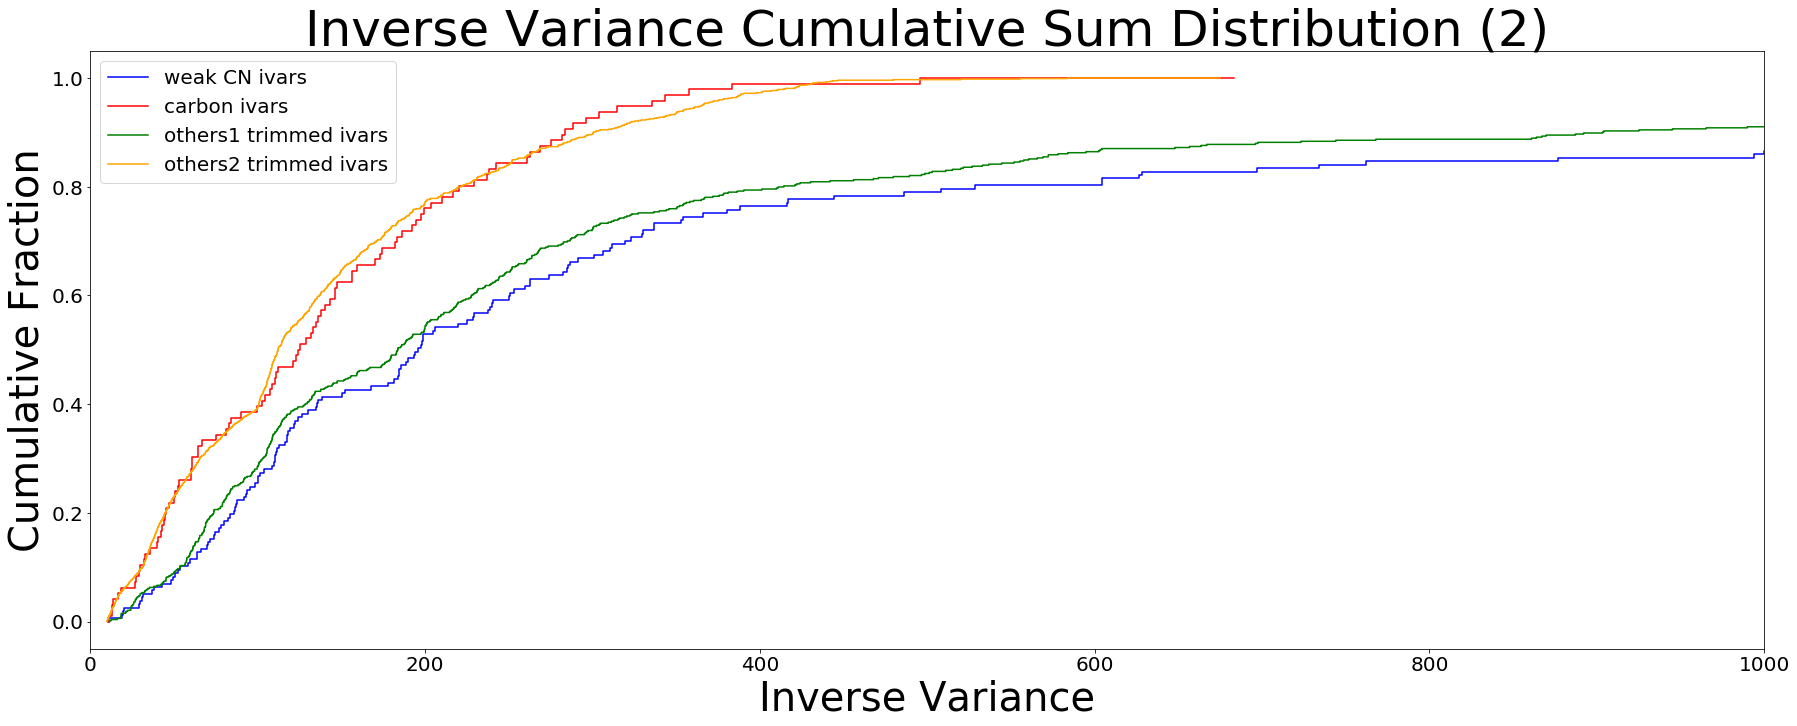

In [43]:
#making unbinned cumulative distribution plots, based on a step of 1/N for each data point
#step 1: sorting the data
wNm_sortedMeds = np.sort(wNm_ivarMeds)
carb_sortedMeds = np.sort(carbon_ivarMeds)
kphO1_sortedMeds = np.sort(kphTrimmedOthers1_ivarMeds)
kphO2select_sortedMeds = np.sort(np.array(kphTrimmedOthers2_ivarMeds))


#step 2: make the cumulative sum as a step function with a step size of 1 / N (where N is set size), so all samples' y's end at 1
plt.step(wNm_sortedMeds, np.linspace(0, 1, len(wNm_sortedMeds)), color = 'blue', label = "weak CN ivars")
plt.step(carb_sortedMeds, np.linspace(0, 1, len(carb_sortedMeds)),  color = 'red', label = "carbon ivars")
plt.step(kphO1_sortedMeds,np.linspace(0, 1, len(kphO1_sortedMeds)), color = 'green', label = "others1 trimmed ivars")
plt.step(kphO2select_sortedMeds,np.linspace(0, 1, len(kphO2select_sortedMeds)), color = 'orange', label = "others2 trimmed ivars")

#formatting the chart so that it is easy to read
plt.title("Inverse Variance Cumulative Sum Distribution (2)", size = 50) 
plt.xlabel("Inverse Variance", size = 40)
plt.ylabel("Cumulative Fraction", size = 40)
plt.legend(fontsize = 20)
plt.xlim(0, 1000)
plt.rcParams['figure.figsize'] = 30, 11
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
#plt.savefig('ivarDistr_cumulativeSum_others1+2_shaped_final.png')
plt.show()

## Score Calculation: Method 1
Calculates the "score" of a star's normalized spectrum by comparing that to a normalized template spectrum and applying a formula that adds up and weights the differences between the two spectra. Note that in method 1, the template spectrum is unmodified.

In [44]:
#creates a function that calculates the score (a measure of the difference between two spectra) for a certain star's spectrum compared to a certain template spectrum
#note that the input spectra and ivars must be already sliced and normalized
def getScore(templateSpec, scienceSpec, ivars):
    '''
    templateSpec: a Numpy array containing the flux values of the coadded template spectrum
    scienceSpec: a Numpy array containing the flux values at each wavelength of the normalized spectrum for a specific star
    ivars: a Numpy array containing the normalized ivar values at each wavelength of the spectrum for a specific star
    
    Returns finalScore, a float representing the similarity between the two spectra. A lower score indicates greater similarity and a higher score indicates lower similarity
    Note that spectra that cannot be normalized will not have a score associated with them. The function returns a NaN as the score for these spectra
    '''
    templateSpec_list = templateSpec.tolist()
    scienceSpec_list = scienceSpec[~np.isnan(scienceSpec)].tolist()
    if scienceSpec_list == []:
        print("ScoreError: Because this spectrum cannot be normalized, its score cannot be found.")
        return np.nan
    else:
        summedScore = 0
        for wv in range(len(templateSpec_list)):
            score = ((scienceSpec[wv] - templateSpec[wv])**2) * ivars[wv]
            if not np.isnan(score):
                summedScore += score
        summedIvars = 0
        for ivar in ivars:
            if not np.isnan(ivar):
                summedIvars += ivar
        finalScore = (summedScore/summedIvars)**0.5
        return finalScore

#test execution of function
specStar, ivarStar = splashSpecs_dict[19534],splashIvars_dict[19534]
print("Score: " + str(getScore(Wtemplate, specStar, ivarStar)))

Score: 0.38825183880413244


## Data Analysis: Method 1
Uses a template spectrum based on the allcarbon data set. Compares stars to this template with the aim of being able to sort stars into three distinct populations: weak CN, carbon, and normal/other. Main method of analysis is histograms.

### Part 1: Analysis Based on the Full-Range 'W'

In [45]:
#creates dictionaries consisting of every star for which a normalized spectrum can be obtained and a score can be calculated
#in these dictionaries, the keys are star indices and the values are the scores associated with those particular stars
kphOthers_score_dict, kphTrO1_score_dict, kphTrO2_score_dict, others_score_dict = {}, {}, {}, {}
flaggedStars_score_dict, wNm_score_dict, carbon_score_dict = {}, {}, {} 
weak_score_dict, marginal_score_dict = {}, {}

#generating the dictionaries and lists simultaneously
for star in wNm:
    if splashSuccess_dict[star]:
        score1 = getScore(Wtemplate, splashSpecs_dict[star], splashIvars_dict[star])
        wNm_score_dict[star] = score1
        if star in flaggedStars_list:
            flaggedStars_score_dict[star] = score1
        if star in weaks:
            weak_score_dict[star] = score1
        else: #the star is a marginal CN star
            marginal_score_dict[star] = score1
for star in others: 
    if splashSuccess_dict[star]:
        score2 = getScore(Wtemplate, splashSpecs_dict[star], splashIvars_dict[star])
        others_score_dict[star] = score2
        if star in flaggedStars_list:
            flaggedStars_score_dict[star] = score2
        if star in keckPhotoOthers_set:    
            kphOthers_score_dict[star] = score2
            if star in kphTrimmedOthers1: #based on others1
                kphTrO1_score_dict[star] = score2
            if star in kphTrimmedOthers2: #based on others1
                kphTrO2_score_dict[star] = score2
for star in allcarbon:
    if splashSuccess_dict[star]:
        score3 = getScore(Wtemplate, splashSpecs_dict[star], splashIvars_dict[star])
        carbon_score_dict[star] = score3
        if star in flaggedStars_list:
            flaggedStars_score_dict[star] = score3

In [46]:
#metadata: stats used to see how the data fits the weak CN hypothesis
print(st.mean(carbon_score_dict.values()), st.mean(wNm_score_dict.values()), st.mean(kphOthers_score_dict.values()))
print(st.median(carbon_score_dict.values()), st.median(wNm_score_dict.values()), st.median(kphOthers_score_dict.values()))

(0.34290997659678846, 0.09356613507108294, 0.36824256218809975)
(0.33912972343621417, 0.0804199913913379, 0.2626052191793642)


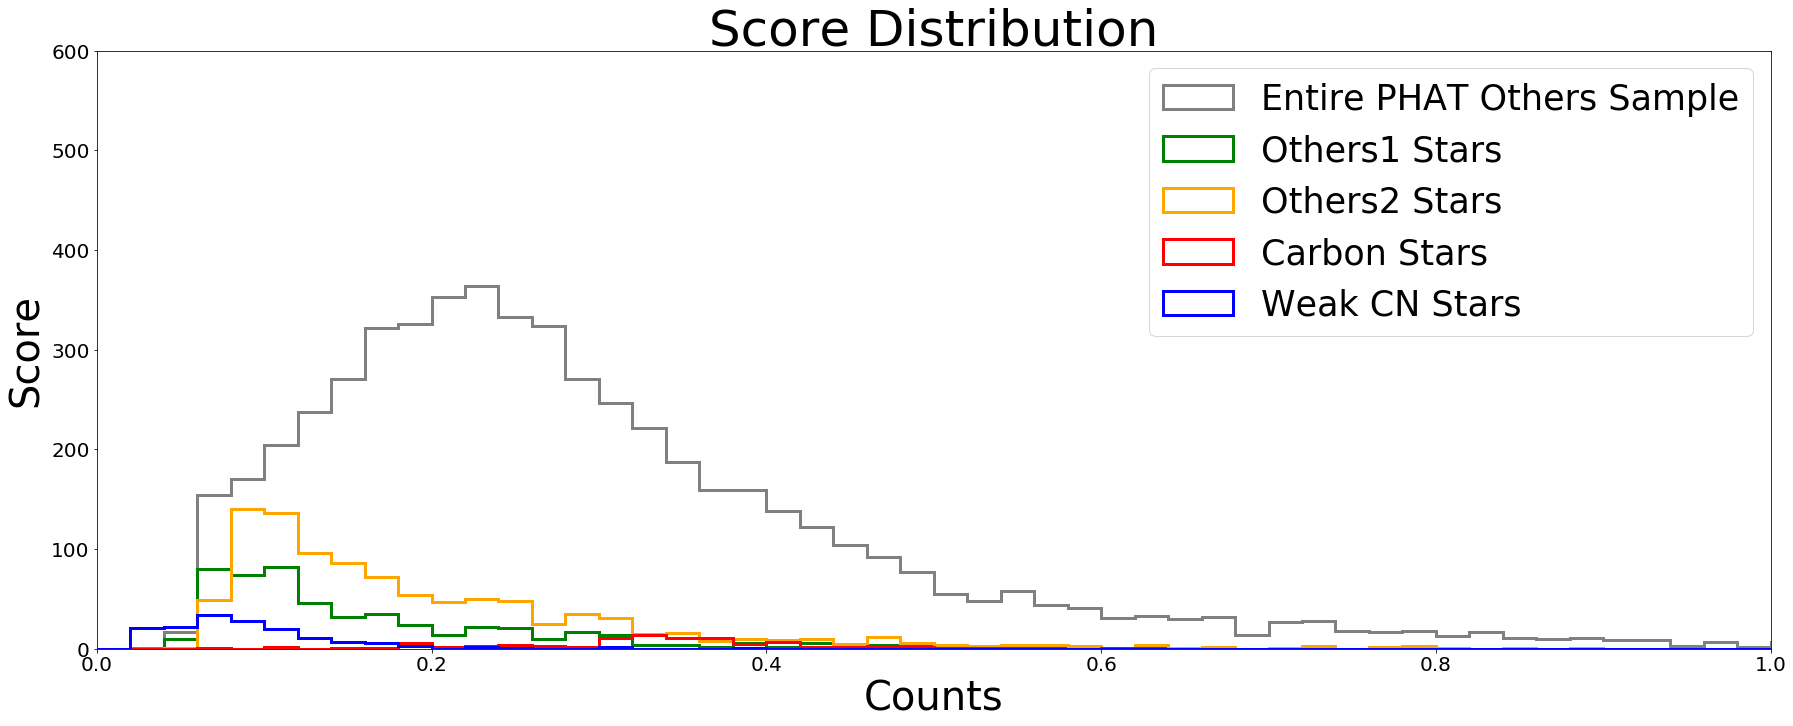

In [47]:
#creates a histogram of the score distributions of valid, able-to-be-normalized stars in SPLASH
binList = np.arange(0, 10, 0.02)

defaultHist([kphOthers_score_dict.values(),kphTrO1_score_dict.values(),kphTrO2_score_dict.values(),carbon_score_dict.values(),wNm_score_dict.values()],
           binList, ['gray','g','orange','r','b'], ["Entire PHAT Others Sample", "Others1 Stars", "Others2 Stars", "Carbon Stars", "Weak CN Stars"],
           ["Score Distribution", "Counts", "Score"], xLim=(0,1),yLim=(0,600), step=3)
#entire PHAT others sample is "ghost" sample to show differences


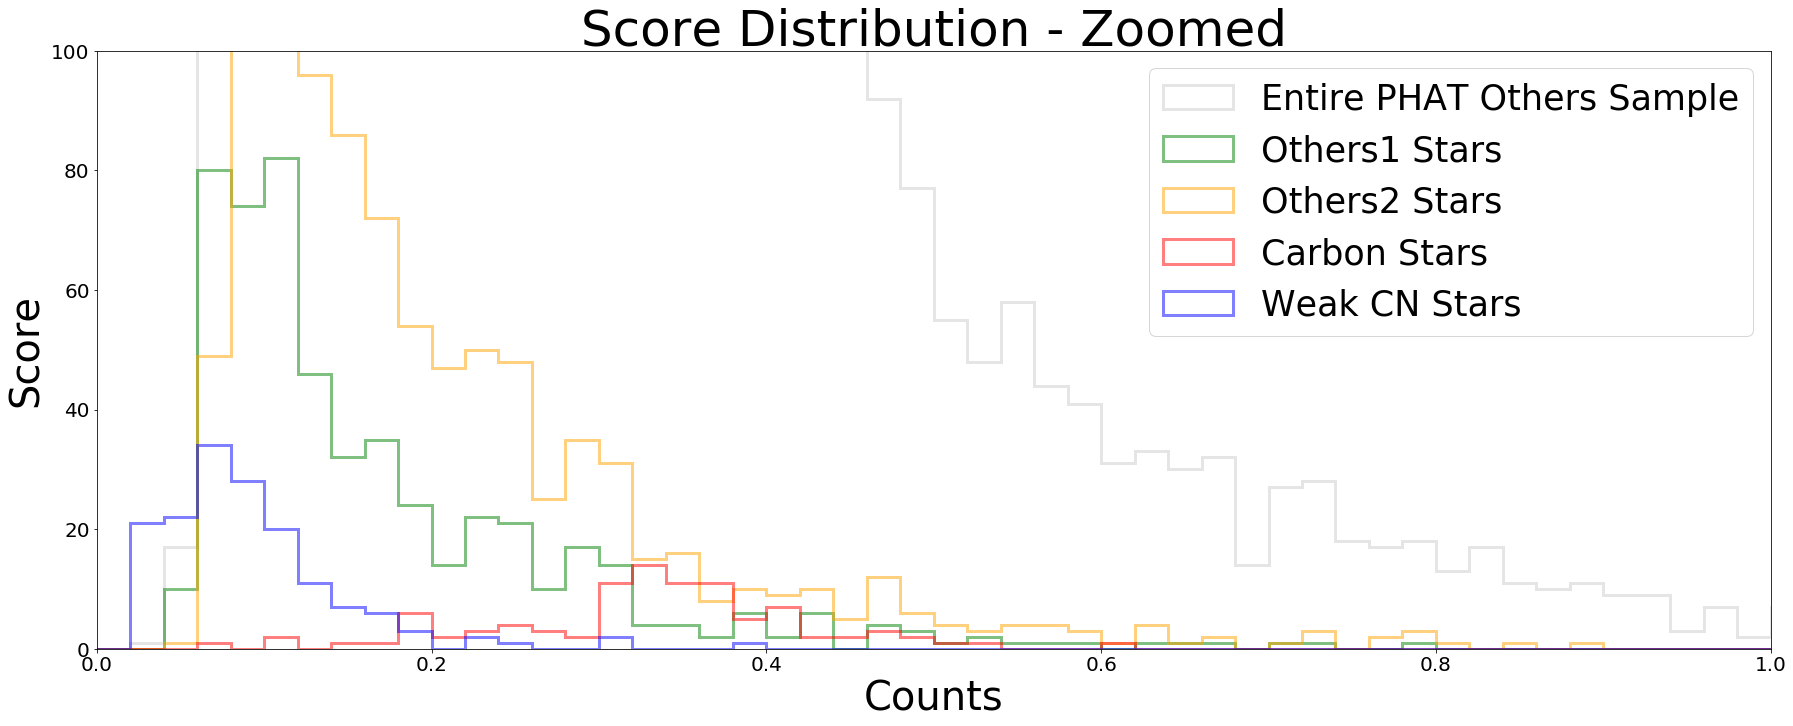

In [48]:
#same histogram as above, just zoomed in on the bottom corner so trends in the weak CN and carbon stars can be observed
#creates a histogram of the score distributions of valid, able-to-be-normalized stars in SPLASH
binList = np.arange(0, 10, 0.02)
defaultHist([kphOthers_score_dict.values(),kphTrO1_score_dict.values(),kphTrO2_score_dict.values(),carbon_score_dict.values(),wNm_score_dict.values()],
           binList, ['gray','g','orange','r','b'], ["Entire PHAT Others Sample", "Others1 Stars", "Others2 Stars", "Carbon Stars", "Weak CN Stars"],
           ["Score Distribution - Zoomed", "Counts", "Score"], xLim=(0,1),yLim=(0,100), alphas=(0.2,0.5,0.5,0.5,0.5), step = 3, fileName="kphScoreDistribution.png")
